In [139]:
%matplotlib inline

In [140]:
import shutil, errno
from glob import glob as glb

def copyanything(src, dest_dir):
    for filename in glb(os.path.join(src, '*.*')):
        shutil.copy(filename, dest_dir)


In [141]:
def PDF(url):
    return HTML('<iframe src=./tmp_figures/%s width=700 height=350></iframe>' % url)

This notebook is aimed at getting all the effector candidates from the Pst_104E_genome as defined as the following.
EffectorP prediction done by Jana Sperschneider
Gene expression cluster analysis done by Jana Sperschneider picking cluster 2, 3 and 8
Out of this list two BUSCOs were removed as they are pretty conserved proteins and are simply coming from the upregulated cluster.

In [142]:
import os
from Bio import SeqIO
import pandas as pd
import re
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [143]:
#define your input folders
#define your input folders updated for haplotigs
CLUSTER_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering'
EFFECTORP_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/Secretomes/EffectorP'
GFF_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
PROTEIN_ANNO_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/pa_26062017'
OUT_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists'
OUT_FOLDER_FIG = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/figures'
TMP_FIG_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/downstream_analysis_2017/scripts/tmp_figures'

In [144]:
if not os.path.exists(OUT_FOLDER_FIG):
    os.mkdir(OUT_FOLDER_FIG)

In [145]:
genome = 'Pst_104E_v12_'
p_effector_list = []
h_effector_list = []
p_effector_seq_list = []
h_effector_seq_list = []
p_effectorp_list = []
h_effectorp_list = []
p_effectorp_seq_list = []
h_effectorp_seq_list = []

In [146]:
#define what you want to take clusters are from the expression analysis
clusters = [ 2,3,8]
clusters_files = [os.path.join(CLUSTER_FOLDER, x) for x in os.listdir(CLUSTER_FOLDER)\
                 if x.startswith('Cluster') and x.endswith('_DEs.fasta') and\
                  any(str(y) in x for y in clusters) ] #fixed to check if any of the clusters are
                                    #in the file header
effectorp_files = [os.path.join(EFFECTORP_FOLDER, x) for x in os.listdir(EFFECTORP_FOLDER)\
                  if x.endswith('effectors.fasta') and x.startswith(genome)]

In [147]:
clusters_files

['/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering/Cluster8_DEs.fasta',
 '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering/Cluster3_DEs.fasta',
 '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering/Cluster2_DEs.fasta']

In [148]:
#get all the sequence names into a list from the fasta headers 
for file in clusters_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id:
            h_effector_list.append(seq.id)
            h_effector_seq_list.append(seq)
        if 'pcontig' in seq.id:
            p_effector_list.append(seq.id)
            p_effector_seq_list.append(seq)
    fh.close()

for file in effectorp_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id and seq.id not in h_effector_list:
            h_effector_list.append(seq.id)
            h_effector_seq_list.append(seq)
        if 'pcontig' in seq.id and seq.id not in p_effector_list:
            p_effector_list.append(seq.id)
            p_effector_seq_list.append(seq)
    fh.close()
    
for file in effectorp_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id:
            h_effectorp_list.append(seq.id)
            h_effectorp_seq_list.append(seq)
        if 'pcontig' in seq.id:
            p_effectorp_list.append(seq.id)
            p_effectorp_seq_list.append(seq)
    fh.close()

In [149]:
#define the effector file name
p_effector_file = os.path.join(OUT_FOLDER, genome + 'p_effector.list')
p_effectorp_file = os.path.join(OUT_FOLDER, genome + 'p_effectorp.list')

In [150]:
#now get BUSCO list in order to remove the two BUSCOs from the effector candidate list
p_busco_file = [os.path.join(PROTEIN_ANNO_FOLDER, x) for x in os.listdir(PROTEIN_ANNO_FOLDER) if x.startswith(genome+'p_ctg') and 'busco' in x][0]
p_busco_list = pd.read_csv(p_busco_file, header=None, sep='\t')[0].tolist()

In [151]:
#write out effectors without BUSCOs
effector_busco_overlap = [x for x in p_effector_list if x in p_busco_list]
print(effector_busco_overlap)
#remove those two from the effector list and update the effectors
#one is a peptidase and the other an ER cargo protein both are fairly conserved
print("This is the number of effector candidates before removal: %i" % len(p_effector_list))
updated_effector_seq_list = []
for x in effector_busco_overlap:
    p_effector_list.remove(x)
for seq in p_effector_seq_list:
    if seq.id not in effector_busco_overlap:
        updated_effector_seq_list.append(seq)
print("This is the number of effector candidates after removal of BUSCOs: %i" % len(p_effector_list))

['evm.model.pcontig_041.167', 'evm.model.pcontig_042.2']
This is the number of effector candidates before removal: 1574
This is the number of effector candidates after removal of BUSCOs: 1572


In [152]:
#write out effectorps without BUSCOs
effectorp_busco_overlap = [x for x in p_effectorp_list if x in p_busco_list]
print(effectorp_busco_overlap)
#remove those two from the effector list and update the effectors
#one is a peptidase and the other an ER cargo protein both are fairly conserved
print("This is the number of effector candidates before removal: %i" % len(p_effectorp_list))
updated_effectorp_seq_list = []
for x in effectorp_busco_overlap:
    p_effectorp_list.remove(x)
for seq in p_effectorp_seq_list:
    if seq.id not in effectorp_busco_overlap:
        updated_effectorp_seq_list.append(seq)
print("This is the number of effectorp candidates after removal of BUSCOs: %i" % len(p_effectorp_list))

['evm.model.pcontig_041.167', 'evm.model.pcontig_042.2']
This is the number of effector candidates before removal: 1071
This is the number of effectorp candidates after removal of BUSCOs: 1069


In [153]:
#subset the gff files as well and write those out
p_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('anno.gff3') ][0]

In [154]:
#get repeat gff files
p_repeat_gff_fn = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.gff') ][0]

In the command line in /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis the superfamily gff files were sorted as followed and copied over into the lists folder
sort Pst_104E_v12_h_ctg.REPET.superfamily.gff -k1,1n -k4,4n > Pst_104E_v12_h_ctg.REPET.sorted.superfamily.gff

In [155]:
#get repeat gff files
p_repeat_superfamily_gff_fn = [os.path.join(OUT_FOLDER, x) for x in os.listdir(OUT_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.sorted.superfamily.gff') ][0]


In [156]:
#gff header 
gff_header = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']

In [157]:
#now subset the gff files for effectors only
p_gff_df = pd.read_csv(p_gff_file, header = None, sep='\t', names= gff_header)
p_gff_df['ID'] = p_gff_df.attributes.str.extract(r'ID=([^;]*);', expand=False)
p_gff_df.sort_values(by=['seqid', 'start'], inplace = True)


In [158]:
#now sort REPET gff and write out again
p_repeat_gff_df = pd.read_csv(p_repeat_gff_fn, header=None, sep='\t', names=gff_header, comment='#')
p_repeat_gff_fn = os.path.join(OUT_FOLDER,p_repeat_gff_fn.split('/')[-1] )
p_repeat_gff_df.sort_values(by=['seqid', 'start']).to_csv(p_repeat_gff_fn, header=None, index=None, sep='\t')


In [159]:
#now define the filenames
p_effector_bed_fn = p_effector_file.replace('.list', '.gene.bed')
p_effector_gff_fn = p_effector_file.replace('.list', '.gene.gff3')    
p_noeffector_bed_fn = p_effector_file.replace('p_effector.list', 'p_noeffector.gene.bed')
p_noeffector_gff_fn = p_effector_file.replace('p_effector.list', 'p_noeffector.gene.gff3')    
p_noeffector_list_fn = p_effector_file.replace('p_effector.list', 'p_noeffector.list')
#effectorp
p_effectorp_bed_fn = p_effectorp_file.replace('.list', '.gene.bed')
p_effectorp_gff_fn = p_effectorp_file.replace('.list', '.gene.gff3')    
p_noeffectorp_bed_fn = p_effectorp_file.replace('p_effectorp.list', 'p_noeffectorp.gene.bed')
p_noeffectorp_gff_fn = p_effectorp_file.replace('p_effectorp.list', 'p_noeffectorp.gene.gff3')    
p_noeffectorp_list_fn = p_effectorp_file.replace('p_effectorp.list', 'p_noeffectorp.list')
#get BUSCO filenames
p_busco_list_fn = p_effector_file.replace('effector.list', 'busco.list')
p_busco_gff_fn = p_effector_file.replace('effector.list', 'busco.gene.gff3')
p_busco_bed_fn = p_effector_file.replace('effector.list', 'busco.gene.bed')

In [198]:
#write out BUSCO for pcontigs
p_busco_list_fn = p_effector_file.replace('effector.list', 'busco.list')
p_busco_gff_fn = p_effector_file.replace('effector.list', 'busco.gene.gff3')
p_busco_bed_fn = p_effector_file.replace('effector.list', 'busco.gene.bed')
#write out non BUSCO for pcontigs
p_non_busco_list_fn = p_effector_file.replace('effector.list', 'non_busco.list')
p_non_busco_gff_fn = p_effector_file.replace('effector.list', 'non_busco.gene.gff3')
p_non_busco_bed_fn = p_effector_file.replace('effector.list', 'non_busco.gene.bed')
#doulbe nos
p_noeffector_nobusco_bed_fn = p_effector_file.replace('effector.list', 'no_busco_no_effector.gene.bed')    
p_noeffectorp_nobusco_bed_fn = p_effectorp_file.replace('effectorp.list', 'no_busco_no_effectorp.gene.bed')
p_gene_bed_fn = p_effector_file.replace('effector.list', 'all.gene.bed') 

Ran up to here for now

In [161]:
#get the distances

#read in files and generate bedtool objects. Issue might be that same variable are used for the bed files
#while those are sometimes gff and sometimes bed. Needs changing
p_effector_bed = BedTool(p_effector_gff_fn)
p_noeffector_bed = BedTool(p_noeffector_gff_fn)
p_busco_bed = BedTool(p_busco_gff_fn)
p_repeats_bed = BedTool(p_repeat_superfamily_gff_fn)
p_non_busco_bed = BedTool(p_non_busco_bed_fn)


#get closest repeat and make a df out of it
p_closest_rep_to_eff = p_effector_bed.closest(p_repeats_bed, d=True)
p_closest_rep_to_eff_df = p_closest_rep_to_eff.to_dataframe()

#here subset the repeat superfamily GFF to filder out smaller repeats if wanted
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

#read this in as repeat_df
p_repeats_bed = BedTool(tmp_fn)

/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 19 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [162]:
#bed closest header when using gff as input files
bed_repeat_closest_header = [x +'_gene' for x in gff_header] + [x +'_repeat' for x in gff_header] + ['distance']

In [163]:
import warnings
warnings.filterwarnings('ignore')

Effectors closest Repeat
                 18
count   1572.000000
mean    2934.840331
std     4141.793597
min        0.000000
25%      357.750000
50%     1241.500000
75%     4017.500000
max    42804.000000


(0, 10000)

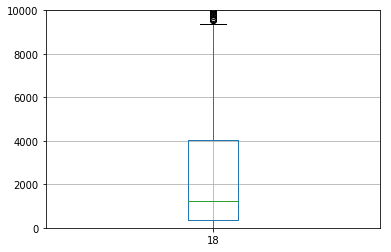

In [164]:
print('Effectors closest Repeat')
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

Repeat closest effector
                  18
count   40544.000000
mean    46099.282064
std     48802.340095
min         0.000000
25%     12474.750000
50%     29779.500000
75%     62678.250000
max    350531.000000


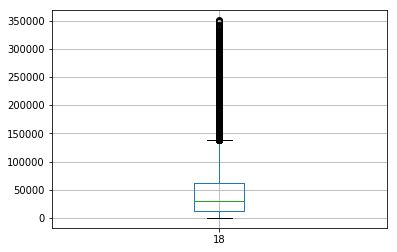

In [165]:
print('Repeat closest effector')
print(p_repeats_bed.closest(p_effector_bed,d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_effector_bed, d=True, t='last').to_dataframe().boxplot(column=18)


BUSCO distance to closest repeat
                 18
count   1444.000000
mean    2938.963989
std     4085.483570
min        0.000000
25%      452.500000
50%     1321.000000
75%     3907.250000
max    41225.000000


(0, 10000)

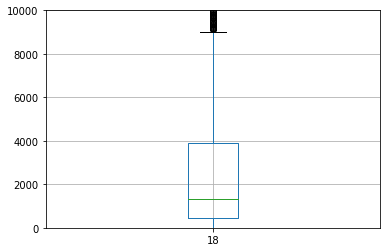

In [166]:
print('BUSCO distance to closest repeat')
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

BUSCO distance to closest repeat
                  18
count   29483.000000
mean    42894.173829
std     48094.906810
min         0.000000
25%     10795.000000
50%     26583.000000
75%     55637.500000
max    330582.000000


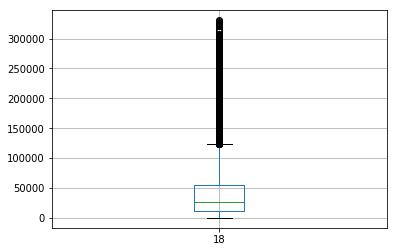

In [167]:
print('BUSCO distance to closest repeat')
print(p_repeats_bed.closest(p_busco_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_busco_bed, d=True,t='last').to_dataframe().boxplot(column=18)


No Effector distance to closest repeat
                 18
count  14273.000000
mean    2217.240244
std     3693.510969
min        0.000000
25%        0.000000
50%      741.000000
75%     2884.000000
max    55526.000000


(0, 10000)

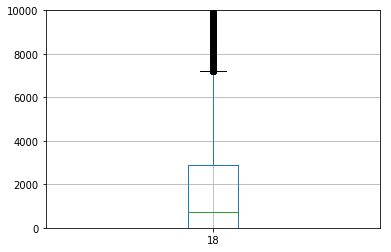

In [168]:
print('No Effector distance to closest repeat')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

Relative distance from TE elements to other elements


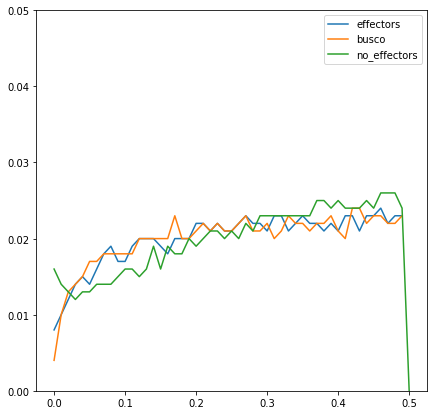

In [169]:
print('Relative distance from TE elements to other elements')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_repeats_bed.reldist(p_effector_bed)['reldist'], p_repeats_bed.reldist(p_effector_bed)['fraction'], label ='effectors')
plt.plot(p_repeats_bed.reldist(p_busco_bed)['reldist'], p_repeats_bed.reldist(p_busco_bed)['fraction'], label= 'busco')
plt.plot(p_repeats_bed.reldist(p_noeffector_bed)['reldist'], p_repeats_bed.reldist(p_noeffector_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

Relative distance of other elements to TEs


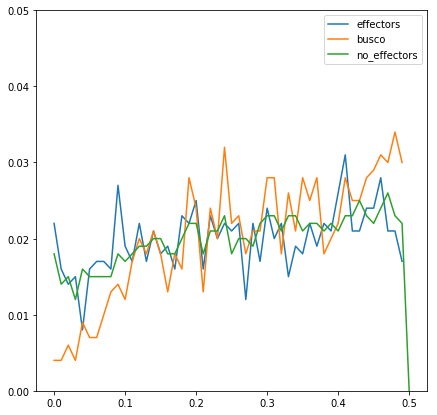

In [170]:
print('Relative distance of other elements to TEs')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_repeats_bed)['reldist'], p_effector_bed.reldist(p_repeats_bed)['fraction'], label ='effectors')
plt.plot(p_busco_bed.reldist(p_repeats_bed)['reldist'], p_busco_bed.reldist(p_repeats_bed)['fraction'], label= 'busco')
plt.plot(p_noeffector_bed.reldist(p_repeats_bed)['reldist'], p_noeffector_bed.reldist(p_repeats_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

In [171]:
#some stuff in the following lines

In [172]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_noeffector_bed)*100

17
ClassII:MITE:?                3.538590
ClassI:LTR:?                  3.914739
ClassII:TIR:PIF-Harbinger     4.569518
ClassII:TIR:Tc1-Mariner       4.806353
ClassII:TIR:hAT               8.414600
ClassI:LARD:?                 8.762887
ClassI:LTR:Copia              9.348008
ClassII:TIR:?                 9.898300
ClassII:?:?                  12.642797
ClassI:LTR:Gypsy             18.250209
Name: 0, dtype: float64

In [173]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_effector_bed)*100

17
ClassII:TIR:PIF-Harbinger     3.180662
ClassII:TIR:Tc1-Mariner       3.625954
ClassI:LTR:?                  4.452926
ClassII:MITE:?                5.152672
ClassI:LTR:Copia              8.778626
ClassII:TIR:hAT               9.096692
ClassII:TIR:?                10.114504
ClassI:LARD:?                10.877863
ClassI:LTR:Gypsy             14.122137
ClassII:?:?                  17.239186
Name: 0, dtype: float64

In [174]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_busco_bed)*100

17
ClassI:LTR:?                  4.362881
ClassII:TIR:PIF-Harbinger     4.432133
ClassII:TIR:Tc1-Mariner       5.401662
ClassII:MITE:?                5.747922
ClassI:LTR:Copia              7.963989
ClassII:TIR:hAT               8.518006
ClassI:LARD:?                10.526316
ClassII:TIR:?                12.119114
ClassI:LTR:Gypsy             13.573407
ClassII:?:?                  15.858726
Name: 0, dtype: float64

In [175]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassII:TIR:hAT             3189.162393
ClassII:?:Sola              3290.000000
ClassI:LTR:Gypsy            3528.756906
ClassII:TIR:Tc1-Mariner     3675.421053
ClassII:Helitron:?          3765.230769
ClassI:LINE:Jockey          3832.500000
ClassII:TIR:MuDR            3947.156250
ClassII:Maverick:?          4384.285714
ClassI:LTR:ERV              7696.000000
ClassII:?:Academ           10287.000000
Name: 18, dtype: float64

In [176]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassII:?:Sola              2419.437500
noCat                       2523.402899
ClassII:TIR:hAT             2570.000864
ClassII:TIR:MuDR            2608.134259
ClassII:TIR:?               2743.119031
ClassII:TIR:Tc1-Mariner     2775.314675
ClassII:Helitron:?          2827.692308
ClassI:LINE:Jockey          3003.733333
ClassII:MITE:?              3250.652273
ClassI:LTR:ERV             10918.400000
Name: 18, dtype: float64

In [177]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassI:LTR:Copia           3183.162602
ClassI:LTR:Gypsy           3231.149038
ClassII:MITE:?             3260.383562
ClassII:TIR:?              3320.779874
ClassII:TIR:hAT            3695.187050
noCat                      3752.581395
ClassI:TRIM:?              3884.500000
ClassII:TIR:Tc1-Mariner    3908.293103
ClassII:Helitron:?         3995.631579
ClassII:TIR:CACTA          6750.200000
Name: 18, dtype: float64

In [178]:
#now lookine at ClassII:?:? specifically
tmp_REPET[(tmp_REPET.distance > 400)&(tmp_REPET.attributes == 'ClassII:?:?')].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)
p_repeats_bed = BedTool(tmp_fn)

Effectors and there closest ClassII:?:? elements
                  18
count    1478.000000
mean    17286.041949
std     18504.676808
min         6.000000
25%      4564.250000
50%     11582.000000
75%     24348.750000
max    194780.000000


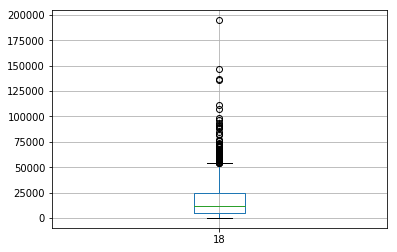

In [179]:
print('Effectors and there closest ClassII:?:? elements')
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last', io=True).to_dataframe().boxplot(column=18)

ClassII:?:? elements and there closest Effectors 
                  18
count    3496.000000
mean    39160.882151
std     43981.650192
min         6.000000
25%      9340.000000
50%     24500.500000
75%     51721.000000
max    327768.000000


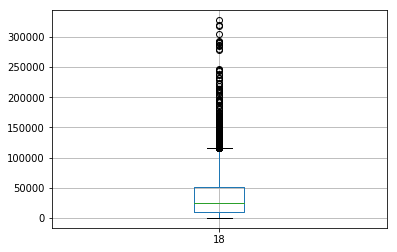

In [180]:
print('ClassII:?:? elements and there closest Effectors ')
print(p_repeats_bed.closest(p_effector_bed, d=True, t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_repeats_bed.closest(p_effector_bed, d=True, t='last', io=True).to_dataframe().boxplot(column=18)

Relative distance from ClassII:?:? elements and other elements


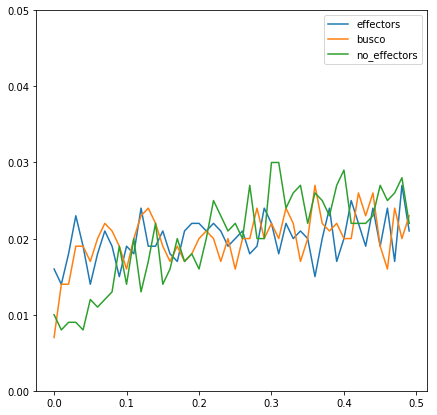

In [181]:
print('Relative distance from ClassII:?:? elements and other elements')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_repeats_bed.reldist(p_effector_bed)['reldist'], p_repeats_bed.reldist(p_effector_bed)['fraction'], label ='effectors')
plt.plot(p_repeats_bed.reldist(p_busco_bed)['reldist'], p_repeats_bed.reldist(p_busco_bed)['fraction'], label= 'busco')
plt.plot(p_repeats_bed.reldist(p_noeffector_bed)['reldist'], p_repeats_bed.reldist(p_noeffector_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

Relative distance of other elements to ClassII:?:?


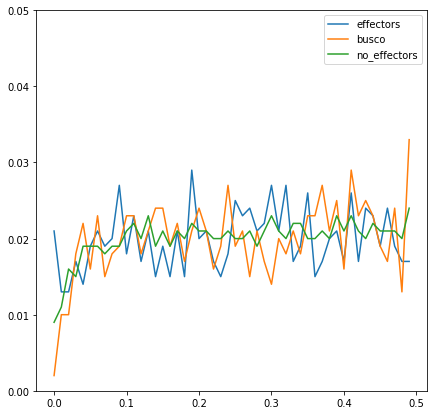

In [182]:
print('Relative distance of other elements to ClassII:?:?')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_repeats_bed)['reldist'], p_effector_bed.reldist(p_repeats_bed)['fraction'], label ='effectors')
plt.plot(p_busco_bed.reldist(p_repeats_bed)['reldist'], p_busco_bed.reldist(p_repeats_bed)['fraction'], label= 'busco')
plt.plot(p_noeffector_bed.reldist(p_repeats_bed)['reldist'], p_noeffector_bed.reldist(p_repeats_bed)['fraction'], label='no_effectors')
plt.ylim(0, 0.05)
plt.legend()

BUSCOs distance to closest ClassII:?:?
                  18
count    1296.000000
mean    17249.780093
std     19339.281875
min         2.000000
25%      4185.000000
50%     11023.000000
75%     23301.250000
max    156673.000000


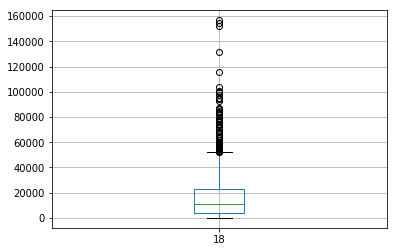

In [183]:
print('BUSCOs distance to closest ClassII:?:?')
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

No effectors distance to closest ClassII:?:?
                  18
count    5302.000000
mean    15810.004715
std     17908.874295
min         2.000000
25%      4179.250000
50%     10144.500000
75%     21210.500000
max    187286.000000


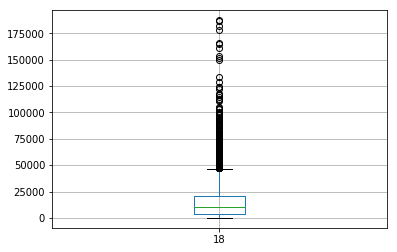

In [184]:
print('No effectors distance to closest ClassII:?:?')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

No effectors distance to closest ClassII:?:? while allowing for overlaps
                  18
count   13770.000000
mean    17446.058533
std     20925.450887
min         0.000000
25%      4024.250000
50%     10807.000000
75%     23028.000000
max    190204.000000


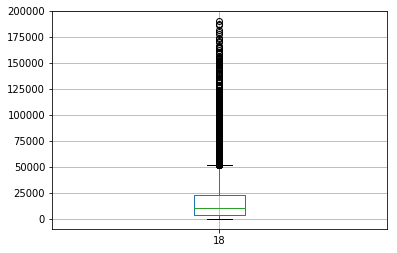

In [185]:
print('No effectors distance to closest ClassII:?:? while allowing for overlaps')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)

Relative distance of between BUSCOS and effectors


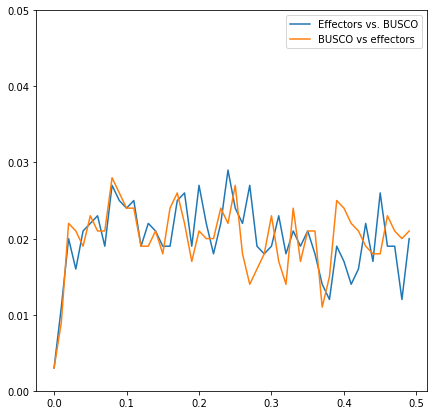

In [186]:
#look at if effectors and buscos are linked or further apart using the redist function
print('Relative distance of between BUSCOS and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_busco_bed)['reldist'], p_effector_bed.reldist(p_busco_bed)['fraction'], label ='Effectors vs. BUSCO')
plt.plot(p_busco_bed.reldist(p_effector_bed)['reldist'], p_busco_bed.reldist(p_effector_bed)['fraction'], label= 'BUSCO vs effectors')

plt.ylim(0, 0.05)
plt.legend()

Relative distance of between non-effectors and effectors


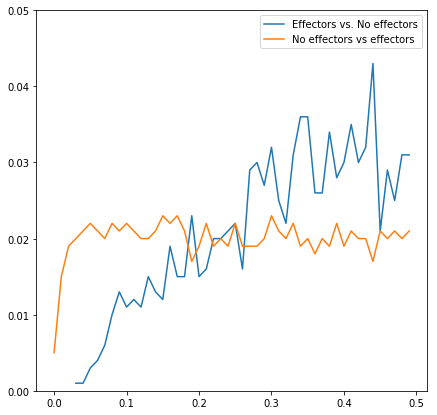

In [187]:
print('Relative distance of between non-effectors and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_effector_bed.reldist(p_noeffector_bed)['reldist'], p_effector_bed.reldist(p_noeffector_bed)['fraction'], label ='Effectors vs. No effectors')
plt.plot(p_noeffector_bed.reldist(p_effector_bed)['reldist'], p_noeffector_bed.reldist(p_effector_bed)['fraction'], label= 'No effectors vs effectors')

plt.ylim(0, 0.05)
plt.legend()

Relative distance of between non-effectors and effectors


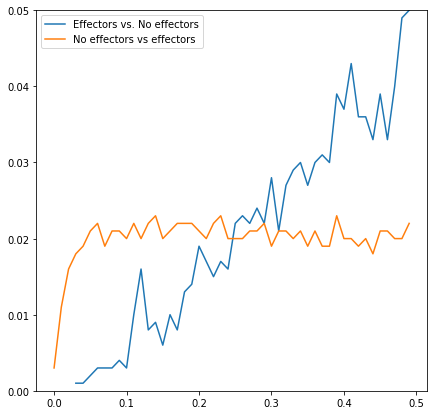

In [188]:
print('Relative distance of between non-effectors and effectors')
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(p_busco_bed.reldist(p_non_busco_bed)['reldist'], p_busco_bed.reldist(p_non_busco_bed)['fraction'], label ='Effectors vs. No effectors')
plt.plot(p_non_busco_bed.reldist(p_busco_bed)['reldist'], p_non_busco_bed.reldist(p_busco_bed)['fraction'], label= 'No effectors vs effectors')

plt.ylim(0, 0.05)
plt.legend()

[]

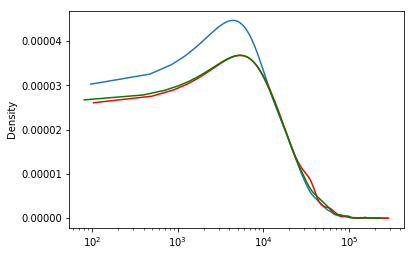

In [189]:
#densities without overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

[]

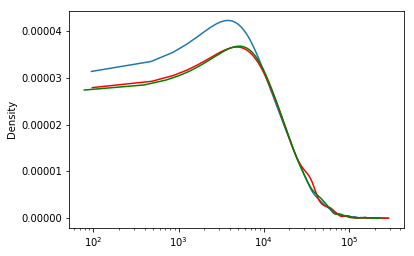

In [190]:
#densities with overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

In [191]:
#define repeats
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [192]:
#summary of closest TEs not allowing for overlaps 
#####Needs fixing for genes that don't have a nearest neighbou######
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

,,mean_noeffector,superfamily_%_noeffector,mean_busco,superfamily_%_busco,mean_effector,superfamily_%_effector
attributes_repeat,,,,,,,
ClassII:Helitron:?,distance,3139.50,0.96,4449.82,0.76,3995.63,1.21
ClassII:TIR:CACTA,distance,3110.65,2.47,6555.92,0.90,6315.53,1.21
ClassI:DIRS:DIRS,distance,1695.24,1.25,2274.42,1.32,2698.60,1.59
ClassII:TIR:MuDR,distance,2911.69,3.19,4569.71,1.94,2969.60,2.74
noCat,distance,2699.79,2.64,2771.70,2.08,3834.91,2.74
ClassII:TIR:PIF-Harbinger,distance,1975.57,4.59,2674.48,4.43,2032.52,3.18
ClassII:TIR:Tc1-Mariner,distance,3067.33,4.82,3836.76,5.40,4464.65,3.63
ClassI:LTR:?,distance,2495.17,3.93,2769.40,4.36,2808.36,4.45
ClassII:MITE:?,distance,3133.07,3.55,2909.45,5.75,3257.52,5.15


In [193]:
#summary of closest TEs allowing for overlaps
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

,,mean_noeffector,superfamily_%_noeffector,mean_busco,superfamily_%_busco,mean_effector,superfamily_%_effector
attributes_repeat,,,,,,,
ClassII:TIR:CACTA,distance,2326.32,1.88,2993.24,0.77,6750.20,1.19
ClassI:DIRS:DIRS,distance,1399.24,1.02,2160.70,1.47,2282.96,1.51
ClassII:Helitron:?,distance,2827.69,1.18,3765.23,0.85,3995.63,1.51
ClassII:TIR:MuDR,distance,2608.13,3.16,3947.16,2.09,3129.58,2.86
ClassII:TIR:PIF-Harbinger,distance,1469.21,4.29,2284.90,4.26,1485.02,3.18
noCat,distance,2523.40,2.79,2868.71,2.17,3752.58,3.18
ClassI:LTR:?,distance,2214.76,3.98,2485.55,4.57,1964.95,3.50
ClassII:TIR:Tc1-Mariner,distance,2775.31,5.02,3675.42,5.42,3908.29,3.82
ClassII:MITE:?,distance,3250.65,4.48,2998.27,5.96,3260.38,5.72


Add some sub_sets for randommization to get equal sized groups

In [194]:
#set the size of the subset here
sub_set = len(p_busco_bed)

In [199]:
p_effector_bed = BedTool(p_effector_bed_fn)
p_allgene_bed = BedTool(p_gene_bed_fn)
p_busco_bed = BedTool(p_busco_bed_fn)
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

In [202]:
#get some randomly subsampled beds of non_busco_non_effectors
p_non_busco_non_effector_bed = BedTool(p_noeffector_nobusco_bed_fn)
p_no_b_no_e_rand_sub = p_non_busco_non_effector_bed.random_subset(sub_set)
for n in range(0,10):
    fn_n = p_noeffector_nobusco_bed_fn.replace('.gene.bed', '.randsub_%s.gene.bed'%n)
    p_no_b_no_e_rand_sub = p_non_busco_non_effector_bed.random_subset(sub_set)
    p_no_b_no_e_rand_sub.to_dataframe().to_csv(fn_n, sep='\t', header=None, index=None)


count     1419.00
mean     22305.07
std      33895.50
min        133.00
25%       3181.00
50%       9994.00
75%      26771.50
max     357617.00
Name: Effectors, dtype: float64


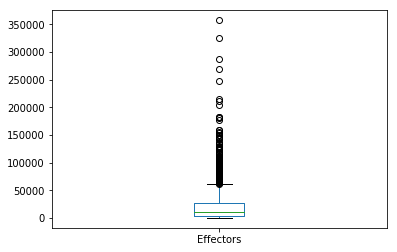

In [203]:
#get the distances with nearest gene effectors vs effectors
p_eself = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eself = p_eself[p_eself > -1]
p_eself.name = 'Effectors'
p_eall = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eall= p_eall[p_eall > -1]
print(p_eself.describe())
p_eself.plot(kind='box')

count     1424.00
mean     28339.83
std      31251.06
min         14.00
25%       6399.25
50%      17829.00
75%      38514.00
max     209219.00
Name: All_genes, dtype: float64


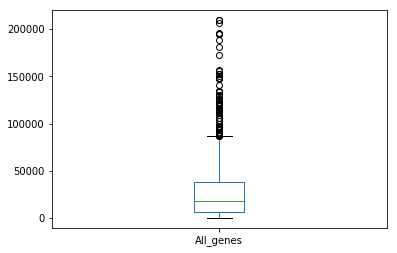

In [204]:
#get the distances with nearest gene all vs all subsampled
p_allall = p_allall_rand_sub.closest(p_allall_rand_sub, d=True, N=True).to_dataframe().iloc[:,12]
p_allall = p_allall[p_allall > -1]
p_allall.name = 'All_genes'
print(p_allall.describe())
p_allall.plot(kind='box')

count     1431.00
mean     24105.67
std      32325.42
min         44.00
25%       4692.00
50%      13565.00
75%      29552.00
max     318595.00
Name: BUSCO, dtype: float64


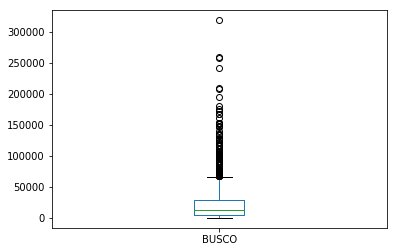

In [205]:
#now with buscos
p_bself = p_busco_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_bself = p_bself[p_bself > -1]
p_bself.name = 'BUSCO'
print(p_bself.describe())
p_bself.plot(kind='box')

count     1425.00
mean     27534.85
std      31964.04
min          8.00
25%       5915.00
50%      16679.00
75%      36365.00
max     301829.00
Name: No_effectors, dtype: float64


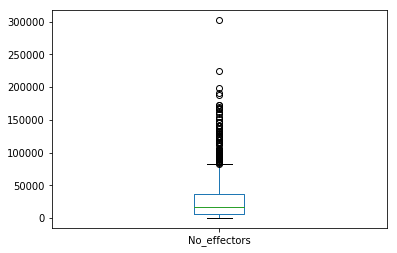

In [206]:
#non_effectors
p_noeffector_bed= BedTool(p_noeffector_bed_fn)
p_noeffector_rand_sub = p_noeffector_bed.random_subset(sub_set)
p_neself = p_noeffector_rand_sub.closest(p_noeffector_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_neself = p_neself[p_neself > -1]
p_neself.name = 'No_effectors'
print(p_neself.describe())
p_neself.plot(kind='box')

Look if effectors and BUSCOs are actually linked
The question is if effectors are close to buscos than other genes. So do busco and effectors link together.

-> are busco more likely closest genes to effectors and vice versa
-> are the distance between busco and random genes larger than busco and effectors

effectors distance to closest Busco


count     1433.00
mean     24810.24
std      33632.53
min        281.00
25%       4345.00
50%      13813.00
75%      33008.00
max     339166.00
Name: Closest Busco to effector, dtype: float64

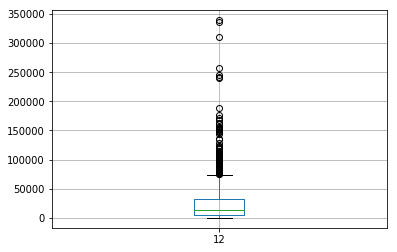

In [207]:
print('effectors distance to closest Busco')
p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
effector_busco_c_df = p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
effector_busco_c_df = effector_busco_c_df[effector_busco_c_df>-1]
effector_busco_c_df.name = "Closest Busco to effector"
effector_busco_c_df.describe()

Closest effector to busco


count     1432.00
mean     29634.50
std      37198.37
min        281.00
25%       4954.00
50%      15774.50
75%      40630.75
max     287609.00
Name: Closest effector to busco, dtype: float64

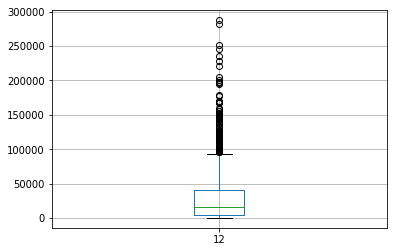

In [208]:
print('Closest effector to busco')
p_busco_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
busco_effector_c_df = p_busco_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
busco_effector_c_df = busco_effector_c_df[busco_effector_c_df>-1]
busco_effector_c_df.name = 'Closest effector to busco'
busco_effector_c_df.describe()

effectors distance to closest rand


count     1431.00
mean     23894.01
std      25584.00
min        120.00
25%       5652.50
50%      15951.00
75%      31856.50
max     227122.00
Name: Closest randsubset to effector, dtype: float64

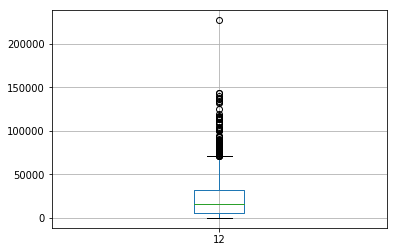

In [209]:
print('effectors distance to closest rand')
p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
effector_randsubset_c_df = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
effector_randsubset_c_df = effector_randsubset_c_df[effector_randsubset_c_df>-1]
effector_randsubset_c_df.name =  "Closest randsubset to effector"
effector_randsubset_c_df.describe()

busco distance to closest rand


count     1426.00
mean     25282.74
std      28482.16
min         16.00
25%       5689.25
50%      16189.00
75%      34439.75
max     244542.00
Name: Closest rand sub to BUSCO, dtype: float64

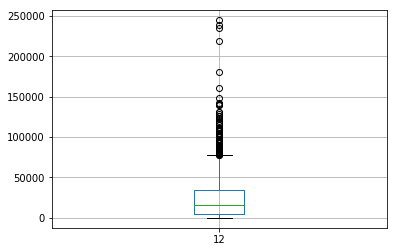

In [210]:
print('busco distance to closest rand')
p_busco_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
busco_rand_sub_c_df = p_busco_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
busco_rand_sub_c_df = busco_rand_sub_c_df[busco_rand_sub_c_df>-1]
busco_rand_sub_c_df.name = "Closest rand sub to BUSCO"
busco_rand_sub_c_df.describe()

rand to closest busco


count     1418.00
mean     31013.18
std      41623.89
min         16.00
25%       6160.50
50%      16827.00
75%      39069.00
max     354826.00
Name: Closest BUSCO to rand subset, dtype: float64

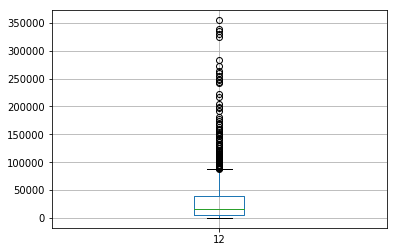

In [211]:
print('rand to closest busco')
p_allall_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
rand_sub_busco_c_df = p_allall_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
rand_sub_busco_c_df = rand_sub_busco_c_df[rand_sub_busco_c_df>-1]
rand_sub_busco_c_df.name = 'Closest BUSCO to rand subset'
rand_sub_busco_c_df.describe()

Rand to closest effector


count     1420.00
mean     35060.50
std      45878.03
min        120.00
25%       6159.50
50%      19471.00
75%      45691.50
max     366580.00
Name: Closest effector to rand subset, dtype: float64

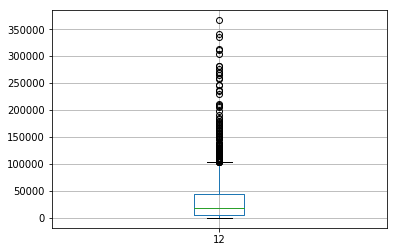

In [212]:
print('Rand to closest effector')
p_allall_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
rand_subset_effector_c_df = p_allall_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
rand_subset_effector_c_df = rand_subset_effector_c_df[rand_subset_effector_c_df>-1]
rand_subset_effector_c_df.name ='Closest effector to rand subset'
rand_subset_effector_c_df.describe()

In [213]:
#all against others both ways to see if effectors are closer to buscos compared to random subset
all_vs_others_c_df = \
 pd.concat([busco_effector_c_df,rand_subset_effector_c_df,effector_busco_c_df,rand_sub_busco_c_df,  \
             effector_randsubset_c_df, busco_rand_sub_c_df ], axis=1)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

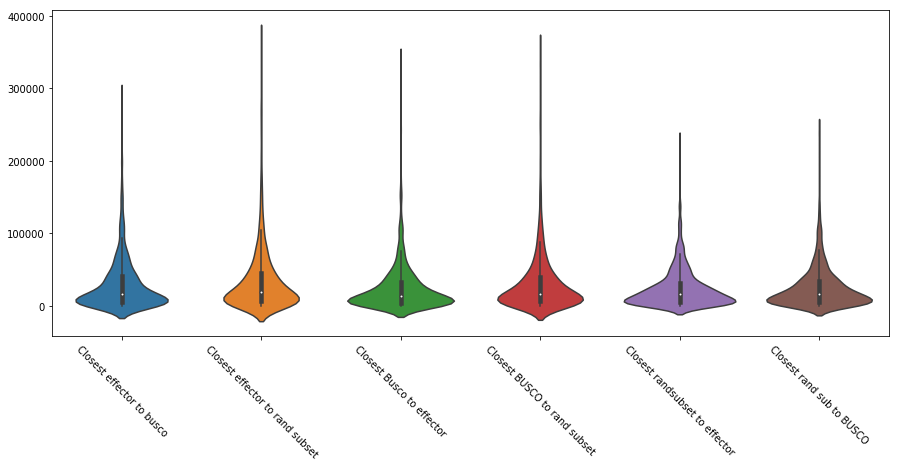

In [214]:
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=all_vs_others_c_df)
plt.xticks(rotation=-45)

In [215]:
#define a function that subsets a dataframe to the inner quantil residual columnwise
def quant_cut_df(dataframe):
    nn_df = dataframe.copy()
    iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_low.name ='low'
    iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_high.name = 'high'

    iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

    iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
    return iqr_nn_df 



(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

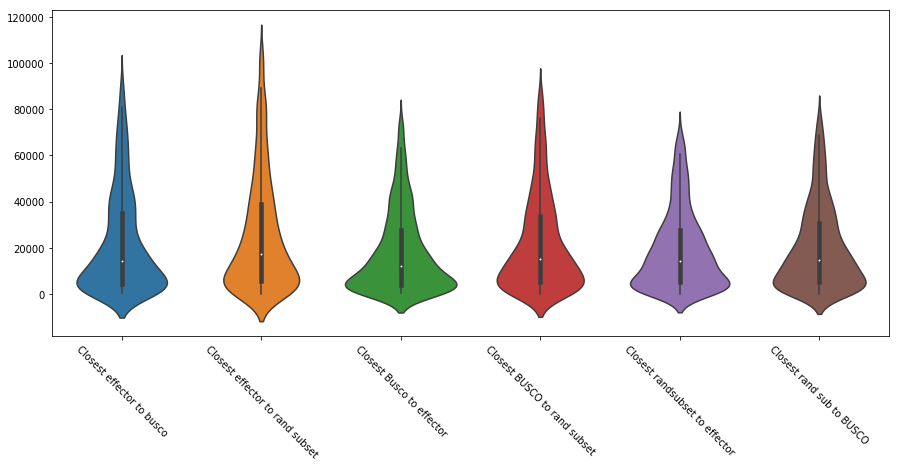

In [216]:
#plot the violine plots for distances once teh iqr is present only
all_vs_others_iqr_df = quant_cut_df(all_vs_others_c_df)
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=all_vs_others_iqr_df)
plt.xticks(rotation=-45)

In [217]:
all_vs_others_iqr_df.columns

Index(['Closest effector to busco', 'Closest effector to rand subset',
       'Closest Busco to effector', 'Closest BUSCO to rand subset',
       'Closest randsubset to effector', 'Closest rand sub to BUSCO'],
      dtype='object')

In [218]:
#do some stats on it look first into ranksum test
scipy.stats.ranksums(all_vs_others_c_df['Closest effector to busco'], all_vs_others_c_df['Closest effector to rand subset'])

RanksumsResult(statistic=-3.58618622006346, pvalue=0.00033554938324503362)

In [219]:
scipy.stats.ranksums(all_vs_others_c_df['Closest Busco to effector'], all_vs_others_c_df['Closest BUSCO to rand subset'])

RanksumsResult(statistic=-4.9099814308249732, pvalue=9.1085017689445518e-07)

In [220]:
scipy.stats.mannwhitneyu(all_vs_others_c_df['Closest Busco to effector'], all_vs_others_c_df['Closest BUSCO to rand subset'],use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=932558.5, pvalue=9.1095312779289733e-07)

In [221]:
scipy.stats.mannwhitneyu(all_vs_others_c_df['Closest effector to busco'], all_vs_others_c_df['Closest effector to rand subset'],use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=962218.5, pvalue=0.0003355779204567425)

In [222]:
all_vs_others_iqr_melt = all_vs_others_iqr_df.melt()

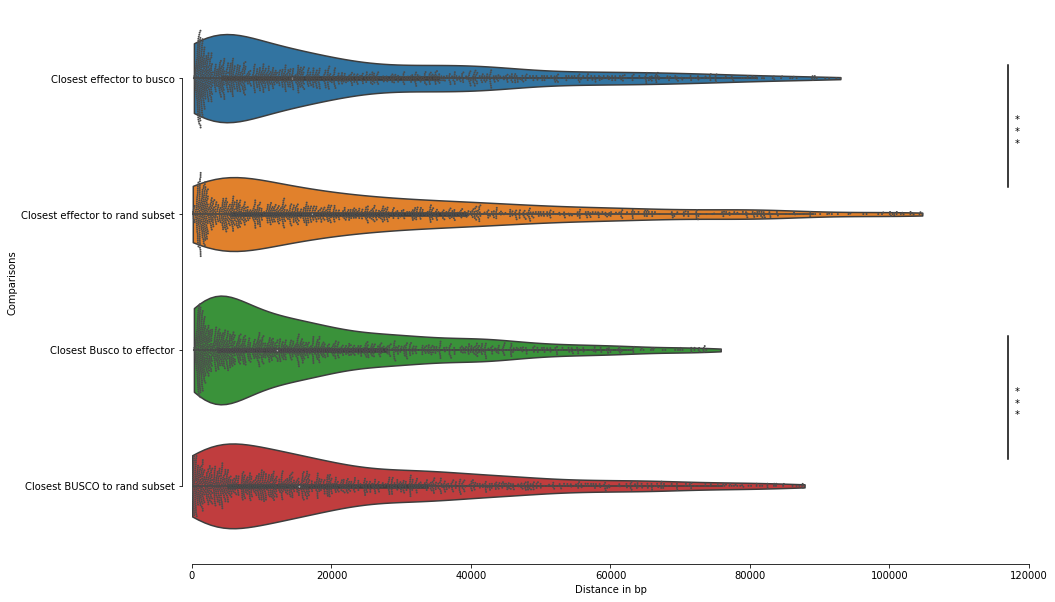

In [223]:
df = all_vs_others_iqr_melt\
    [all_vs_others_iqr_melt.variable.isin(all_vs_others_iqr_df.iloc[:,[0,1,2,3]].columns)].copy()
#do a boxplot and swarmplot on the same data
f, ax = plt.subplots(figsize=(15, 10))
#ax.set_xscale("log")
sns.violinplot(x="value", y="variable", data=df, cut=0,
          whis=np.inf)
plt.setp(ax.artists, alpha=.01)
sns.swarmplot(x="value", y="variable", data=df,
              size=2, color=".3", linewidth=0)
plt.xlim(0, 120000)
plt.ylabel("Comparisons")
plt.xlabel('Distance in bp')
ax.text(118000, 0.5, '*\n*\n*', color='k')
ax.plot([117000, 117000],[-0.1, 0.8], color ='k' )
ax.text(118000, 2.5, '*\n*\n*', color='k')
ax.plot([117000, 117000],[1.9, 2.8], color ='k' )
sns.despine(offset=10, trim=True)

In [224]:
#do a boxplot on the same data using own bining
bins = [x for x in range(0, int(all_vs_others_iqr_df.max().max())+10000,2000 )]
all_vs_others_iqr_melt['bins'] = pd.cut(all_vs_others_iqr_melt.value, bins)
all_vs_others_iqr_hist = all_vs_others_iqr_melt.groupby(by=['variable', 'bins']).count().unstack().T

In [225]:
all_vs_others_iqr_hist['bins'] = all_vs_others_iqr_hist.index.get_level_values(1)

all_vs_others_iqr_hist['bins_left'] = all_vs_others_iqr_hist['bins'].apply(lambda x: x.left)

(-500, 104704.0)

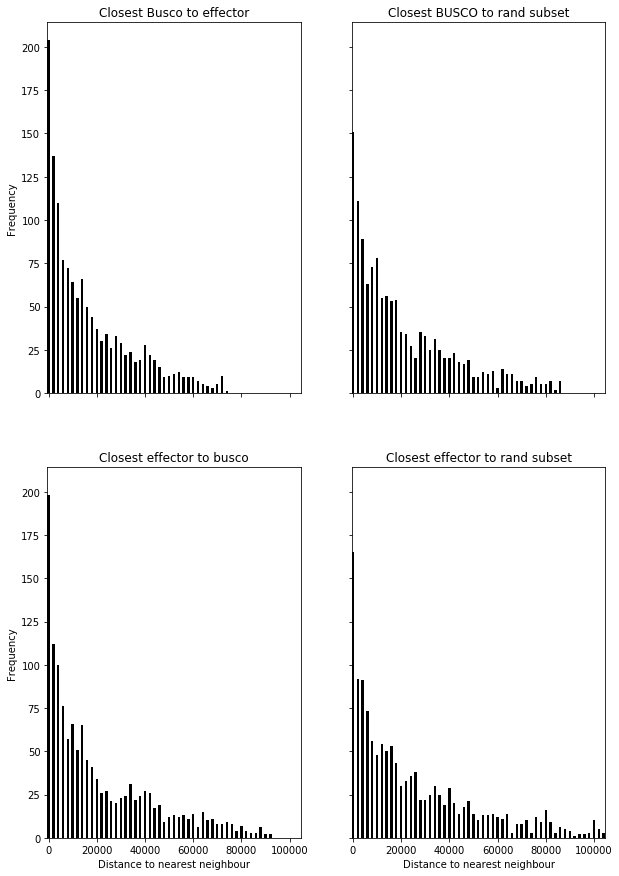

In [226]:
df = all_vs_others_iqr_hist.copy()
_max = all_vs_others_iqr_df.max().max()
fig, ax = plt.subplots(2,2, figsize=(10,15), sharex='all', sharey='all')
for axes, data in zip(ax.flat,  df.iloc[:,[1,0,2,3]].columns ):
    axes.bar(left=  df['bins_left'],height=df.loc[:,data],\
            color='k',width=1000)
    axes.set_title(data)
    
ax[1,0].set_xlabel('Distance to nearest neighbour')
ax[1,1].set_xlabel('Distance to nearest neighbour')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
plt.xlim(-500, _max)

In [227]:
#all_vs_others_iqr_hist.cumsum(axis=0)['Closest Busco to effector'] - all_vs_others_iqr_hist.cumsum(axis=0)['Closest BUSCO to rand subset']

In [228]:
#all_vs_others_iqr_hist.cumsum(axis=0)['Closest effector to busco'] - all_vs_others_iqr_hist.cumsum(axis=0)['Closest effector to rand subset']

In [229]:
#do a boxplot bin the data into same intervals for all and make new data frame out of it
all_vs_others_c_df_melt = all_vs_others_c_df.melt()
bins = [x for x in range(0, int(all_vs_others_c_df_melt.value.max())+10000,2000 )]
all_vs_others_c_df_melt['bins'] = pd.cut(all_vs_others_c_df_melt.value, bins)
all_vs_others_c_df_hist = all_vs_others_c_df_melt.groupby(by=['variable', 'bins']).count().unstack().T
all_vs_others_c_df_hist['bins'] = all_vs_others_c_df_hist.index.get_level_values(1)
all_vs_others_c_df_hist['bins_left'] = all_vs_others_c_df_hist['bins'].apply(lambda x: x.left)


(-500, 366580.0)

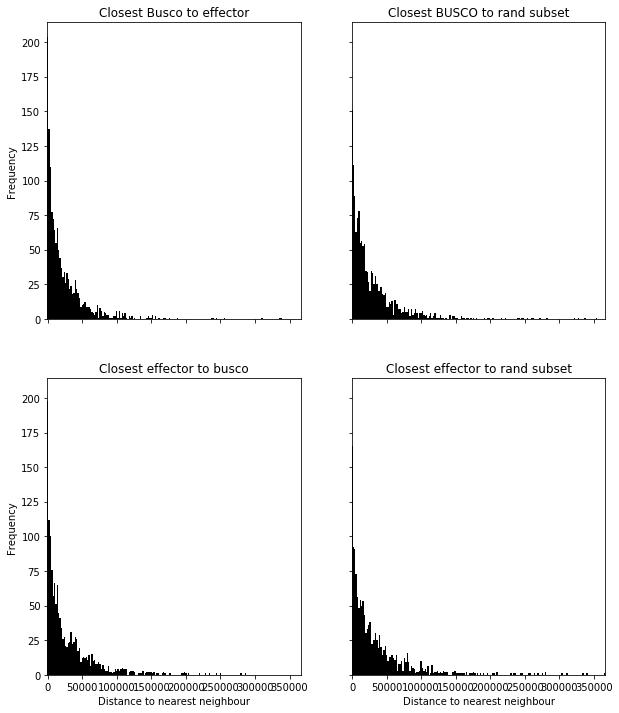

In [230]:
df = all_vs_others_c_df_hist.copy()
_max = all_vs_others_c_df_melt.value.max()
fig, ax = plt.subplots(2,2, figsize=(10,12), sharex='all', sharey='all')
for axes, data in zip(ax.flat,  df.iloc[:,[1,0,2,3]].columns ):
    axes.bar(left=  df['bins_left'],height=df.loc[:,data],\
            color='k',width=2000)
    axes.set_title(data)
    
ax[1,0].set_xlabel('Distance to nearest neighbour')
ax[1,1].set_xlabel('Distance to nearest neighbour')
ax[0,0].set_ylabel('Frequency')
ax[1,0].set_ylabel('Frequency')
plt.xlim(-500, _max)
#all_vs_others_iqr_df.hist(bins=30, figsize=(15,10), sharey='All', sharex="All")

cat Pst_104E_v12_ph_ctg.no_alleles_postQC.txt | xargs -I {} grep "{}" ../../enrichment_analysis/lists/Pst_104E_v12_p_effector.list > ../../enrichment_analysis/lists/Pst_104E_v12_p_effector.noalleles.list

In [231]:
!ls {OUT_FOLDER}

Pst_104E_v12_cluster_8.gene.bed
Pst_104E_v12_cluster_8.gene.gff3
Pst_104E_v12_cluster_8.list
Pst_104E_v12_h_all.gene.bed
Pst_104E_v12_h_all.gene.bed.list
Pst_104E_v12_h_all.gene.gff3
Pst_104E_v12_h_all.gene.list
Pst_104E_v12_h_busco.gene.bed
Pst_104E_v12_h_busco.gene.gff3
Pst_104E_v12_h_busco.list
Pst_104E_v12_h_cluster_15.list
Pst_104E_v12_h_ctg.no_alleles_postQC.PctID70_QCov80.no_exonerate
Pst_104E_v12_h_ctg.no_alleles_postQC.PctID70_QCov80.no_homo
Pst_104E_v12_h_ctg.orphan.PctID80_QCov70.list
Pst_104E_v12_h_ctg.orphan.PctID80_QCov70.no_exonerate.list
Pst_104E_v12_h_ctg.REPET.gff
Pst_104E_v12_h_ctg.REPET.sorted.superfamily.gff
Pst_104E_v12_h_effector.gene.bed
Pst_104E_v12_h_effector.gene.gff3
Pst_104E_v12_h_effector.list
Pst_104E_v12_h_effectorp.gene.bed
Pst_104E_v12_h_effectorp.gene.gff3
Pst_104E_v12_h_effectorp.list
Pst_104E_v12_h_effectorp.protein.fasta
Pst_104E_v12_h_effector.protein.fasta
Pst_104E_v12_h_no_busco_no_effector.gene.bed
Pst_104E_v12_h_no_busco_no_effectorp.gene.bed


In [232]:
#check if effectors without alleles look any different.
orphan_effectors_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_Cluster8_UnderDiversifyingSelection.list')\
                                   , sep='\t', header=None)[0].tolist()

In [233]:
effector_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_effector.list')\
                                   , sep='\t', header=None)[0].tolist()
busco_list = pd.read_csv(os.path.join(OUT_FOLDER,'Pst_104E_v12_p_busco.list')\
                                   , sep='\t', header=None)[0].tolist()

In [234]:
count = 0
for x in effector_list:
    if x in busco_list:
        count = count +1
print(count)

0


In [235]:
len(set(effector_list) -set(busco_list))

1572

In [236]:
test_df  = p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe()

In [237]:
test_df[test_df[3].str.replace('TU', 'model').isin(orphan_effectors_list)].loc[:,12].describe()

count      59.00
mean    15137.19
std     17305.93
min        -1.00
25%      3995.50
50%      9678.00
75%     19203.00
max     87415.00
Name: 12, dtype: float64

In [238]:
test_df.loc[:,12].describe()

count     1444.00
mean     24621.23
std      33573.52
min         -1.00
25%       4228.25
50%      13503.00
75%      32182.75
max     339166.00
Name: 12, dtype: float64

No look a bit more into the distribution of the nearest neighbour distance

In [239]:
import seaborn as sns

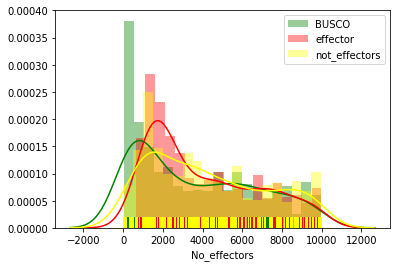

In [240]:
sns.distplot(p_bself[p_bself < 10000], bins=20, rug = True, color='g',label='BUSCO')
sns.distplot(p_eself[p_eself < 10000], bins=20, rug = True, color='red',label = 'effector')
sns.distplot(p_neself[p_neself <10000], bins=20, rug=True, color='yellow', label ='not_effectors')
plt.legend()

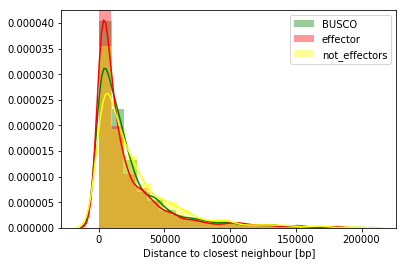

In [241]:
sns.distplot(p_bself[p_bself < 200000], bins=20, color='g' ,label='BUSCO')
sns.distplot(p_eself[p_eself < 200000], bins=20,  color='red',label = 'effector')
sns.distplot(p_neself[p_neself <200000], bins=20,  color='yellow', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

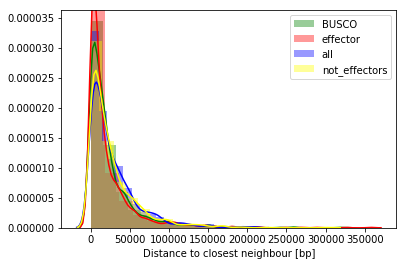

In [242]:
sns.distplot(p_bself, bins=20,color='g',  label='BUSCO')
sns.distplot(p_eself, bins=20,  color='red',label = 'effector')
sns.distplot(p_allall, bins=20,  color='b',label = 'all')
sns.distplot(p_neself, bins=20,  color='yellow', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

In [243]:
#now make a nearest neightbour dataframe
nn_df = pd.concat([p_allall, p_bself, p_eself], names=['All_genes', 'BUSCO', 'effectors'], axis=1)

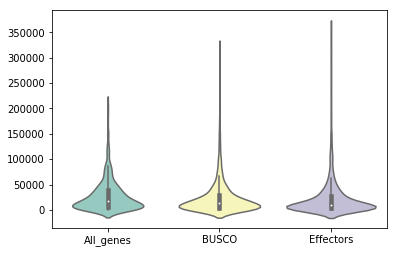

In [244]:
sns.violinplot(data=nn_df, palette="Set3")

In [245]:
#NOW FILTER BY QUANTIELS

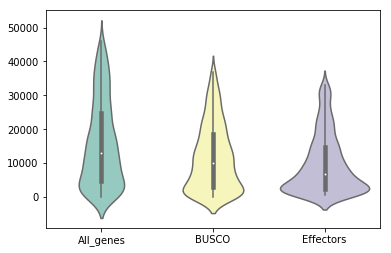

In [246]:
low = 0
high = 0.8
quant_df = nn_df.quantile([low,high])

qfilt_nn_df = nn_df.apply(lambda x: x[(x > quant_df.loc[low, x.name]) & (x  < quant_df.loc[high, x.name])], axis=0)

sns.violinplot(data=qfilt_nn_df , palette="Set3")

In [247]:
#now filter on IQR

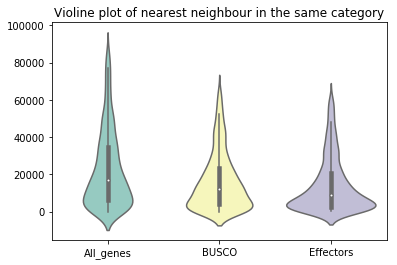

In [248]:
iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_low.name ='low'
iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_high.name = 'high'

iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
plt.title('Violine plot of nearest neighbour in the same category')
sns.violinplot(data=iqr_nn_df  , palette="Set3")

898 963 779 833


(0, 20000)

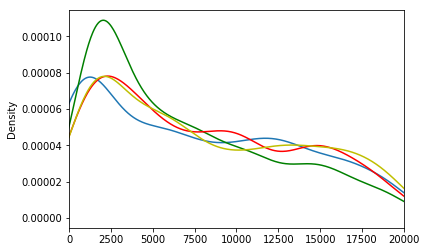

In [249]:
p_bself[p_bself < 20000].plot(kind='density')
p_eself[p_eself < 20000].plot(kind='density', color='g')
p_neself[p_neself < 20000].plot(kind='density', color='r')
p_eall[p_eall < 20000].plot(kind='density', color='y')
#plt.semilogx()
print(len(p_bself[p_bself < 20000]), len(p_eself[p_eself < 20000]), len(p_neself[p_neself < 20000]), len(p_eall[p_eall < 20000]))
plt.xlim(0, 20000)

(0, 0.0002)

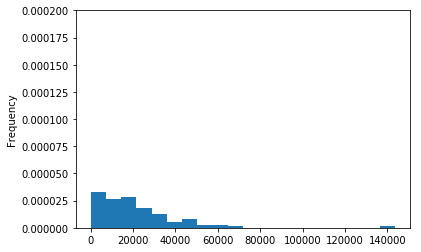

In [250]:
p_eall[p_eall].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00020)

(0, 0.0002)

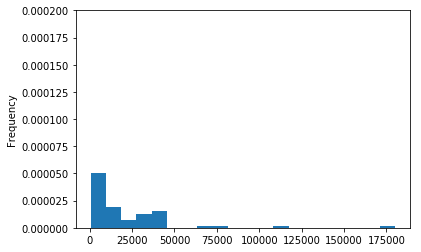

In [251]:
p_eself[p_eself].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00020)

(0, 0.0002)

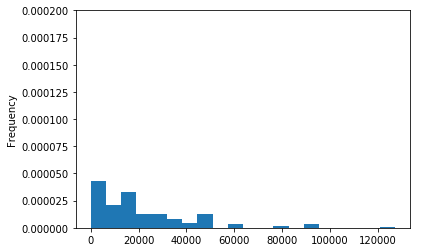

In [252]:
p_bself[p_bself ].plot(kind='hist', bins=20,normed=True)
plt.ylim(0, 0.00020)

(0, 0.0002)

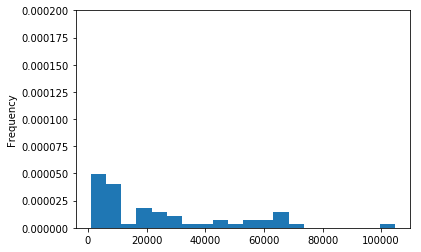

In [253]:
p_neself[p_neself ].plot(kind='hist',bins=20,normed=True)
plt.ylim(0, 0.00020)

It seems like there seems to be no clear link between effector candidates and closest neighbour in terms of TEs in general. They all have the same distance in general.
Maybe Gypsy and ClassII:?:? should be looked at more carefully. Those are depleted and enriched in busco and effector genes. In general there seems to be a trend towards ClassII elements compared to ClassI in effector candidates.
This changes when for allowing for overlaps.

It seems that effectors are closer together than noneffector genes. Buscos also seem to cluster a bit. Let's see if we can visualize the location of genes on certain contigs vs repeats and such.

In [254]:
#start with getting effectors per contig divided by length divded by # of overall genes

In [255]:
#get effectors per contig
effector_bdf = pd.read_csv(p_effector_bed_fn, header=None, sep='\t')

In [256]:
p_effectors_per_contig  = effector_bdf.groupby(0).count()[1]
p_effectors_per_contig.name = 'effectors'

In [257]:
#get all others counts per contig
p_all_genes_per_contig = pd.read_csv(p_gene_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_all_genes_per_contig.name = 'all_genes'
p_noeffectors_per_contig = pd.read_csv(p_noeffector_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_noeffectors_per_contig.name = 'no_effectors'
p_busco_per_contig = pd.read_csv(p_busco_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_busco_per_contig.name = 'buscos'

In [258]:
#read in the genome file that contains the length of each contig in the second column
p_contig_length = pd.read_csv(os.path.join(GFF_FOLDER, 'Pst_104E_v12_p_ctg.genome_file'), header = None,\
                          names=['contig' , 'length'], sep='\t').sort_values('contig')

In [259]:
p_contig_length.index = p_contig_length.contig

p_contig_length = p_contig_length.loc[:, 'length']

gene_dis_per_contig = pd.concat([p_contig_length,p_all_genes_per_contig,p_noeffectors_per_contig,p_busco_per_contig,  p_effectors_per_contig ], axis = 1)

In [260]:
from scipy.stats import chisquare

In [261]:
#fill nan with 0s
gene_dis_per_contig.fillna(value=0, inplace=True)

In [262]:
gene_dis_per_contig.effectors.sum()

1572.0

In [263]:
#chisquare for genes per contig vs bases per contig
chisquare(gene_dis_per_contig.length.values/gene_dis_per_contig.length.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

Power_divergenceResult(statistic=inf, pvalue=0.0)

In [264]:
chisquare(gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

Power_divergenceResult(statistic=nan, pvalue=nan)

In [265]:
#calculate the % of each category that are on a specific contig
gene_dis_per_contig['%busco'] = gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum() *100
gene_dis_per_contig['%effector'] = gene_dis_per_contig.effectors.values/gene_dis_per_contig.effectors.sum() *100
gene_dis_per_contig['%all_genes'] = gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum() *100
gene_dis_per_contig['%no_effector'] = gene_dis_per_contig.no_effectors.values/gene_dis_per_contig.no_effectors.sum() *100

In [266]:
#not sure why this isn't working
chisquare(gene_dis_per_contig['%effector'], f_exp = gene_dis_per_contig['%all_genes'])

Power_divergenceResult(statistic=nan, pvalue=nan)

In [267]:
#have a look at the different percentages
gene_dis_per_contig.loc[:,['%effector', '%all_genes','%no_effector' ,'%busco']]

,%effector,%all_genes,%no_effector,%busco
pcontig_000,2.74,3.66,3.76,3.67
pcontig_001,4.33,3.50,3.41,4.36
pcontig_002,3.37,3.07,3.04,2.49
pcontig_003,4.01,2.93,2.81,2.98
pcontig_004,2.48,2.33,2.31,2.22
pcontig_005,2.61,2.51,2.50,2.84
pcontig_006,2.23,2.70,2.75,3.32
pcontig_007,1.91,2.38,2.43,2.01
pcontig_008,1.15,1.95,2.04,1.80
pcontig_009,2.35,2.10,2.08,2.01


In [268]:
#contigs which % effectors is more than % of all genes or of buscos
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].loc[:,['effectors', '%effector', '%all_genes']].index

Index(['pcontig_002', 'pcontig_003', 'pcontig_004', 'pcontig_009',
       'pcontig_010', 'pcontig_018', 'pcontig_019', 'pcontig_021',
       'pcontig_026', 'pcontig_031', 'pcontig_034', 'pcontig_035',
       'pcontig_036', 'pcontig_039', 'pcontig_044', 'pcontig_045',
       'pcontig_056', 'pcontig_057', 'pcontig_059', 'pcontig_060',
       'pcontig_062', 'pcontig_066', 'pcontig_067', 'pcontig_073',
       'pcontig_078', 'pcontig_080', 'pcontig_081', 'pcontig_088',
       'pcontig_091', 'pcontig_092', 'pcontig_103', 'pcontig_148',
       'pcontig_149', 'pcontig_150', 'pcontig_157', 'pcontig_165',
       'pcontig_173', 'pcontig_186', 'pcontig_207', 'pcontig_235'],
      dtype='object')

In [269]:
#contigs which % effectors is more than % of all genes or of buscos
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].loc[:,['effectors', '%effector', '%all_genes', '%busco']]

,effectors,%effector,%all_genes,%busco
pcontig_002,53.00,3.37,3.07,2.49
pcontig_003,63.00,4.01,2.93,2.98
pcontig_004,39.00,2.48,2.33,2.22
pcontig_009,37.00,2.35,2.10,2.01
pcontig_010,42.00,2.67,2.02,0.83
pcontig_018,41.00,2.61,1.80,1.66
pcontig_019,27.00,1.72,1.61,0.83
pcontig_021,34.00,2.16,1.83,1.73
pcontig_026,27.00,1.72,1.55,1.52
pcontig_031,25.00,1.59,1.05,1.32


In [270]:
#effectors per contig > than expected 1.5 increase?
gene_dis_per_contig[(gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes']) > 1.5].loc[:,['effectors', '%effector', 'all_genes','%all_genes']].index

Index(['pcontig_031', 'pcontig_035', 'pcontig_057', 'pcontig_059',
       'pcontig_078', 'pcontig_103', 'pcontig_149', 'pcontig_150',
       'pcontig_157', 'pcontig_181', 'pcontig_186', 'pcontig_203',
       'pcontig_233', 'pcontig_235'],
      dtype='object')

In [271]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].sum()

length         28655023.00
all_genes          5496.00
no_effectors       4802.00
buscos              443.00
effectors           694.00
%busco               30.68
%effector            44.15
%all_genes           34.51
%no_effector         33.45
dtype: float64

In [272]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%all_genes'] > gene_dis_per_contig['%busco'])].sum()

length         19141462.00
all_genes          3631.00
no_effectors       3205.00
buscos              253.00
effectors           426.00
%busco               17.52
%effector            27.10
%all_genes           22.80
%no_effector         22.33
dtype: float64

In [273]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) ].sum()

length         42654095.00
all_genes          8306.00
no_effectors       7286.00
buscos              777.00
effectors          1020.00
%busco               53.81
%effector            64.89
%all_genes           52.15
%no_effector         50.75
dtype: float64

In [274]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%busco'] > gene_dis_per_contig['%all_genes'])].sum()

length         41028407.00
all_genes          8114.00
no_effectors       7267.00
buscos              908.00
effectors           847.00
%busco               62.88
%effector            53.88
%all_genes           50.94
%no_effector         50.62
dtype: float64

In [275]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) ].sum()

length         42654095.00
all_genes          8306.00
no_effectors       7286.00
buscos              777.00
effectors          1020.00
%busco               53.81
%effector            64.89
%all_genes           52.15
%no_effector         50.75
dtype: float64

In [276]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) & (gene_dis_per_contig['%busco'] > 0.5 )\
                    ].loc[:,['buscos', '%busco', '%all_genes']]

,buscos,%busco,%all_genes
pcontig_001,63.00,4.36,3.50
pcontig_006,48.00,3.32,2.70
pcontig_011,47.00,3.25,2.08
pcontig_022,32.00,2.22,1.70
pcontig_023,31.00,2.15,1.58
pcontig_030,26.00,1.80,1.43
pcontig_031,19.00,1.32,1.05
pcontig_037,25.00,1.73,1.18
pcontig_041,22.00,1.52,1.17
pcontig_042,21.00,1.45,1.10


In [277]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) \
                    ].sum()

length         20730883.00
all_genes          4224.00
no_effectors       3778.00
buscos              527.00
effectors           446.00
%busco               36.50
%effector            28.37
%all_genes           26.52
%no_effector         26.32
dtype: float64

In [278]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.1) & \
                   (gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes'] < 0.9) ].sum()

length         8439506.00
all_genes         1729.00
no_effectors      1609.00
buscos             207.00
effectors          120.00
%busco              14.34
%effector            7.63
%all_genes          10.86
%no_effector        11.21
dtype: float64

In [279]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.0000001) & \
                   (gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes'] < 0.9999) ].sum()

length         17515774.00
all_genes          3439.00
no_effectors       3186.00
buscos              384.00
effectors           253.00
%busco               26.59
%effector            16.09
%all_genes           21.59
%no_effector         22.19
dtype: float64

In [280]:
#enriched for effectors relative to busco and all genes. Seems to be the case that their might be contigs
#with less BUSCOs and more effectors
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%effector'] < 1) & \
                    (gene_dis_per_contig['%all_genes'] / gene_dis_per_contig['%effector'] < 1) ].sum()

length         28655023.00
all_genes          5496.00
no_effectors       4802.00
buscos              443.00
effectors           694.00
%busco               30.68
%effector            44.15
%all_genes           34.51
%no_effector         33.45
dtype: float64

Get closest features genes vs. TEs

In [281]:
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start

tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'tmpsuperfamily.bed')
tmp_REPET[tmp_REPET.distance > 400].loc[:,['seqid', 'start', 'end', 'attributes', 'score', 'strand']].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [282]:
tmp_df = p_effector_bed.closest( [p_repeats_bed.fn,p_allgene_bed.fn] , mdb='all', d=True, N=True).to_dataframe()

tmp_df.rename(columns={10: 'ID'}, inplace=True)

print('Per of effectors having genes as closest feature %f2' % (tmp_df[tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))

print('Per of effectors having TE as closest %f2' % (tmp_df[~tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))


Per of effectors having genes as closest feature 48.2824432
Per of effectors having TE as closest 64.0585242


In [283]:
tmp_df = p_allgene_bed.closest( [p_repeats_bed.fn,p_allgene_bed.fn] , mdb='all', d=True, N=True).to_dataframe()

tmp_df.rename(columns={10: 'ID'}, inplace=True)

print('Per of genes having genes as closest feature %f2' % (tmp_df[tmp_df.ID.str.contains('evm')][0].count()/len(p_allgene_bed)*100))

print('Per of genes having TE as closest %f2' % (tmp_df[~tmp_df.ID.str.contains('evm')][0].count()/len(p_allgene_bed)*100))

Per of genes having genes as closest feature 43.7970872
Per of genes having TE as closest 75.2574082


Get 5 and 3 prime distances of genes

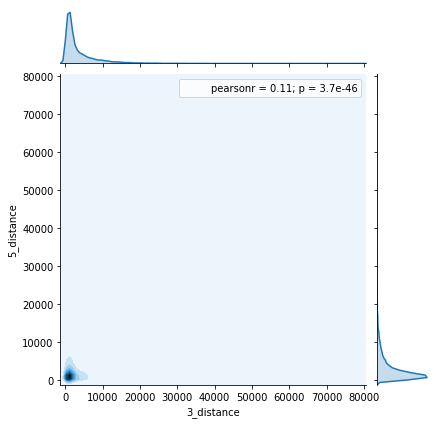

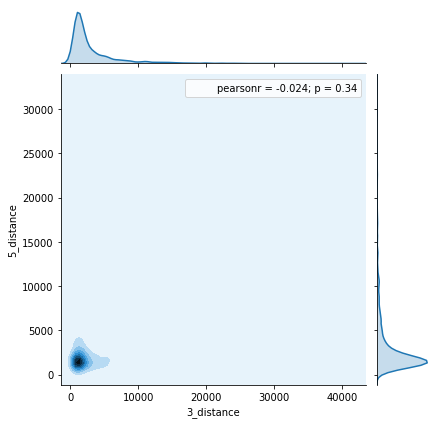

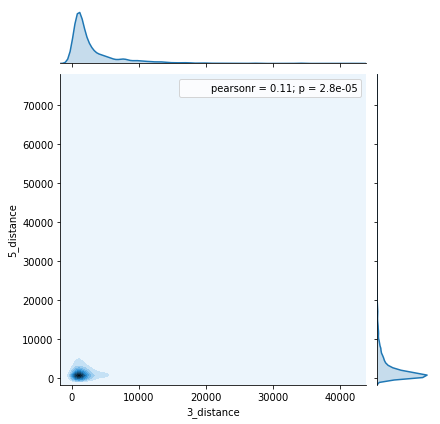

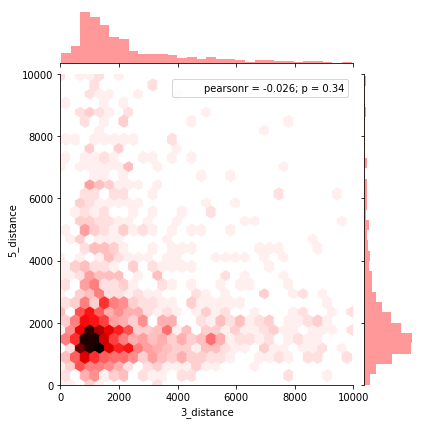

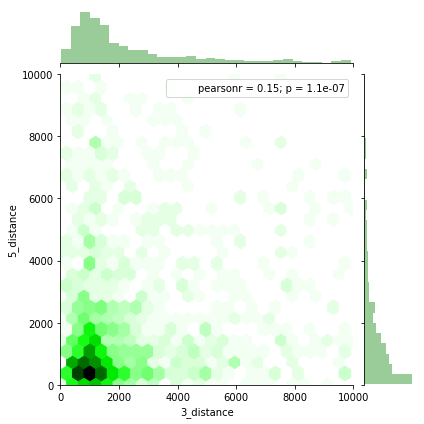

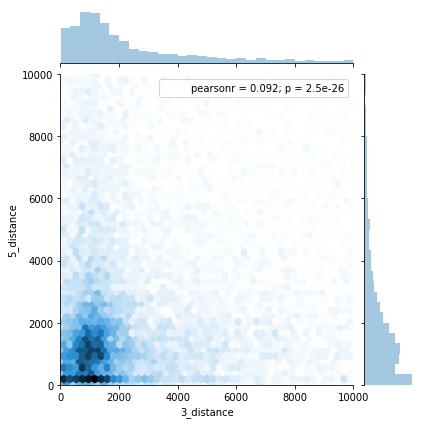

In [284]:
#now get the 3 prime distante to genes using the D='a' and iu flag in bedtools
g_to_g_3 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]


g_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)

#now get the 5 prime distante to genes using the D='a' and id flag in bedtools
g_to_g_5 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
g_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

g_to_g_merged = g_to_g_3.merge(g_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account. Filter out everythign that has a 5' distance of -1 meaning nothing
#and is at the begining of the contig .1 and at the 3' end drop everything that has a negative distance meaning no 3' neighbour

g_to_g_merged = g_to_g_merged[ (g_to_g_merged['5_target'] !='.') &(g_to_g_merged['3_target'] !='.') ]


g_to_g_merged['5_distance'] = abs(g_to_g_merged['5_distance'])
g_to_g_merged['5_distance_log10'] = np.log10(g_to_g_merged['5_distance'])
g_to_g_merged['3_distance_log10'] = np.log10(g_to_g_merged['3_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde")



#do the same for effectors
#now for effectors 
#getting 5' and 3' distance
e_to_g_3 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
e_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_g_5 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
e_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

#merging them
e_to_g_merged = e_to_g_3.merge(g_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges
e_to_g_merged = e_to_g_merged[((e_to_g_merged['5_target'] != '.') & ((e_to_g_merged['3_target'] != '.'))) ]
e_to_g_merged['5_distance'] = abs(e_to_g_merged['5_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde")


#now for busco
b_to_g_3 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
b_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
b_to_g_5 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
b_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
b_to_g_merged = b_to_g_3.merge(b_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges see above for details
b_to_g_merged = b_to_g_merged[((b_to_g_merged['5_target'] !='.') & (b_to_g_merged['3_target'] !='.')) ]
b_to_g_merged['5_distance'] = abs(b_to_g_merged['5_distance'])
sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged, kind="kde")

#now start plotting stuff
#sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
#sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)


#subset everything by fixed numbers maybe to IQR or such in future
sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged[(e_to_g_merged['5_distance'] < 10000) &\
        (e_to_g_merged['3_distance'] < 10000)], kind="hex", color='r',xlim=[0,10000], ylim=[0,10000],\
             marginal_kws=dict(bins=30))


sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged[(b_to_g_merged['5_distance'] < 10000) &\
        (b_to_g_merged['3_distance'] < 10000)], kind="hex",color='g', xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged[(g_to_g_merged['5_distance'] < 10000) &\
        (g_to_g_merged['3_distance'] < 10000)], kind="hex", xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

Now look at the distance to the closest gene of the same group

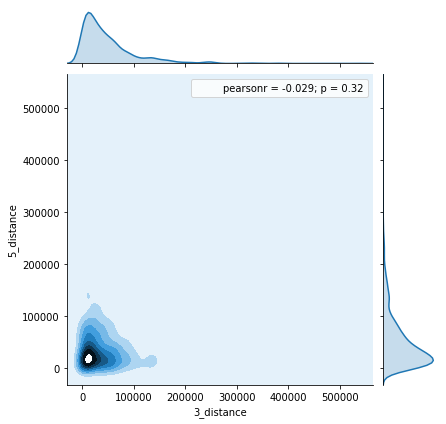

In [285]:
#now get the 3 prime distante to genes using the D='a' and iu flag in bedtools
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

all_all_rand_3 = p_allall_rand_sub.closest( p_allall_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()


all_all_rand_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)

#now get the 5 prime distante to genes using the D='a' and id flag in bedtools
all_all_rand_5 = p_allall_rand_sub.closest( p_allall_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
all_all_rand_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

all_all_rand_merged = all_all_rand_3.merge(all_all_rand_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account. Filter out everythign that has a 5' distance of -1 meaning nothing
#and is at the begining of the contig .1 <- the .1 was no appropriate here as the random subsampling can lead
#to alternative first gene models selected on the respective contig
#extended the initial df of closest to include also queyr and target. Now filtering on no target ='.' possible

all_all_rand_merged = all_all_rand_merged[((all_all_rand_merged['5_target'] != '.')&(all_all_rand_merged['3_target'] != '.')  ) ]



all_all_rand_merged['5_distance'] = abs(all_all_rand_merged['5_distance'])
all_all_rand_merged['5_distance_log10'] = np.log10(all_all_rand_merged['5_distance'])
all_all_rand_merged['3_distance_log10'] = np.log10(all_all_rand_merged['3_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=all_all_rand_merged, kind="kde")



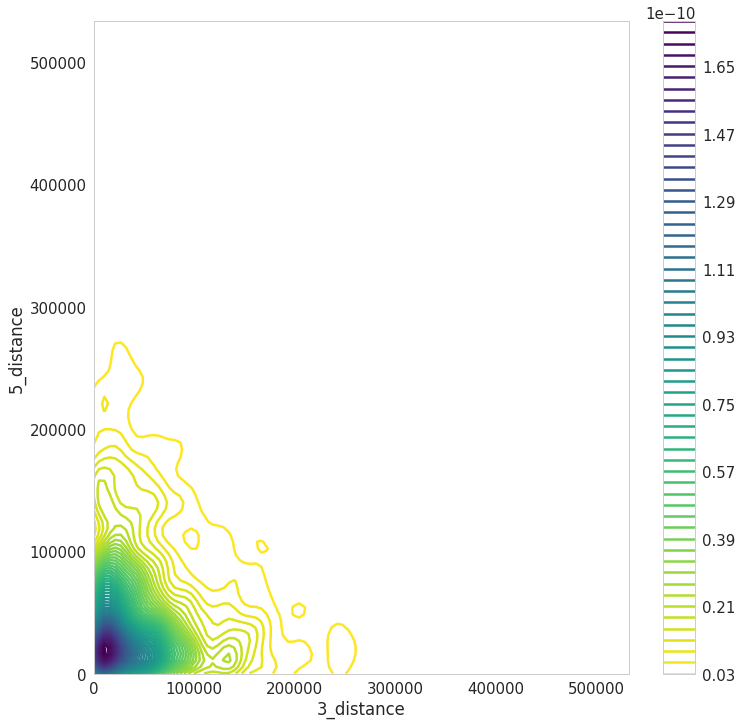

In [525]:
#now try to overlay some scatter plots with 
fig, ax = plt.subplots(figsize=(12,12))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(all_all_rand_merged['3_distance'], all_all_rand_merged['5_distance'],\
            cut=0, ax=ax,cbar=True, cmap='viridis_r', n_levels=60)

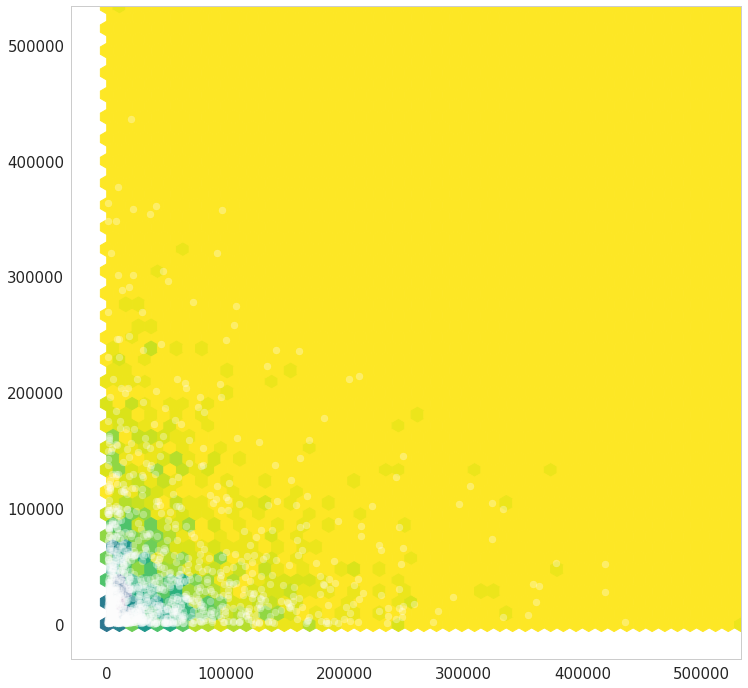

In [531]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12, 12))
ax.hexbin(all_all_rand_merged['3_distance'], all_all_rand_merged['5_distance'], gridsize=50\
        , cmap='viridis_r')
ax.scatter(e_to_e_sub_merged['3_distance'], e_to_e_sub_merged['5_distance'], color='w', alpha=0.3)

In [545]:
len(g_to_g_merged)

15636

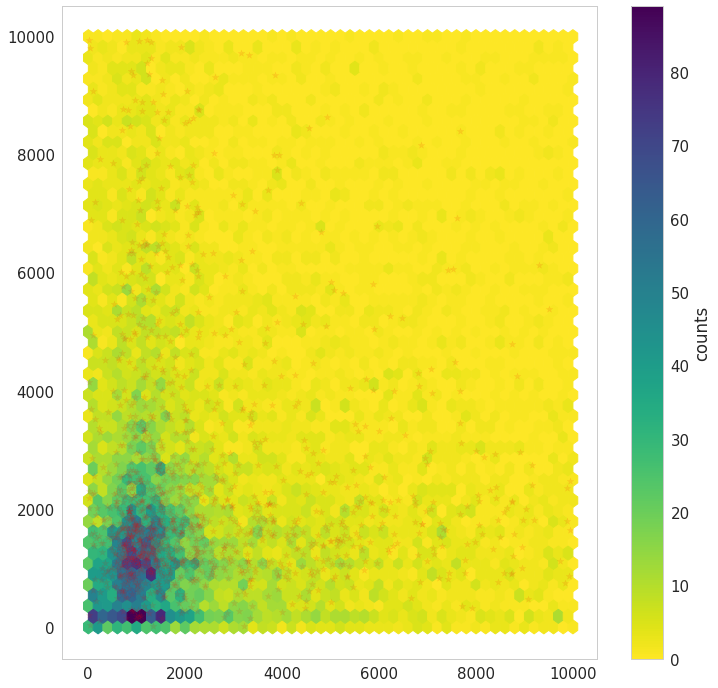

In [554]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12, 12))
limit = g_to_g_merged['3_distance'].max() *0.7
limit = 10000
df = g_to_g_merged
df2 = e_to_g_merged
df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
hb = ax.hexbin(df['3_distance'], df['5_distance'], gridsize=50\
        , cmap='viridis_r')

ax.scatter(df2['3_distance'], df2['5_distance'],\
           color='r', marker='*', alpha=0.1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

In [373]:
#trying to make a contour plot <- why did i waste my time
bins_heat = np.arange(0, 80001, 1000)

In [485]:
prime_3_binned, bin_array = pd.cut(e_to_g_merged['3_distance'], bins_heat, retbins=True)
prime_5_binned = pd.cut(e_to_g_merged['5_distance'], bins_heat)

In [486]:
binned_dis_df = pd.concat([prime_3_binned, prime_5_binned], axis =1)

In [487]:
binned_dis_df['one'] = 1

In [488]:
heatmap_df = binned_dis_df.groupby(['3_distance', '5_distance'])['one'].count().unstack()

In [489]:
hdf =binned_dis_df.groupby(['3_distance', '5_distance'])['one'].count()

In [490]:
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'occurrence']

In [491]:
hdfreset['atter'] = hdfreset.a.apply(lambda x: int(re.findall(r', ([^]]*)', str(x))[0]))
hdfreset['btter'] = hdfreset.b.apply(lambda x: int(re.findall(r', ([^]]*)', str(x))[0]))

In [502]:
hdfpivot=hdfreset.loc[:,['atter', 'btter','occurrence']].pivot('atter', 'btter')
hdfpivot.fillna(0, inplace=True)
len(hdfpivot)

30

In [512]:
hdfreset['atter'].unique()

[1000, 2000, 3000, 4000, 5000, ..., 28000, 29000, 33000, 34000, 43000]
Length: 30
Categories (30, int64): [1000 < 2000 < 3000 < 4000 ... 29000 < 33000 < 34000 < 43000]

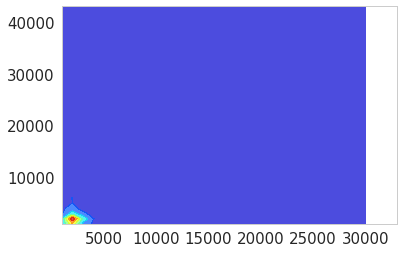

In [514]:
Y=hdfreset['atter'].unique()
X=hdfreset['btter'].unique()
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.contourf(Xi, Yi, Z, alpha=0.7, cmap=plt.cm.jet);

TypeError: Shape of x does not match that of z: found (30, 80) instead of (30, 27).

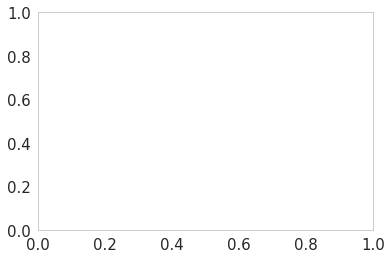

In [495]:
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.contourf(Xi, Yi, Z, alpha=0.7, cmap=plt.cm.jet);

In [515]:
heatmap_df.fillna(0, inplace=True)

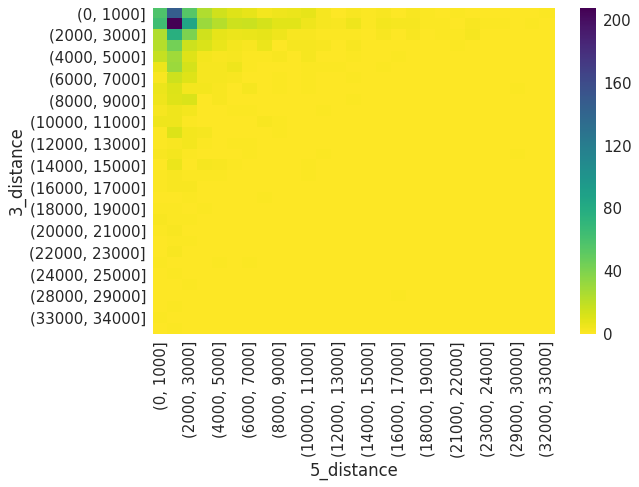

In [519]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(heatmap_df,cmap='viridis_r')

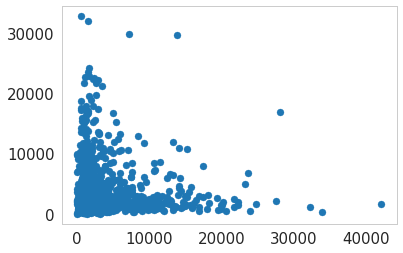

In [353]:
plt.scatter(x=e_to_g_merged['3_distance'], y=e_to_g_merged['5_distance'])

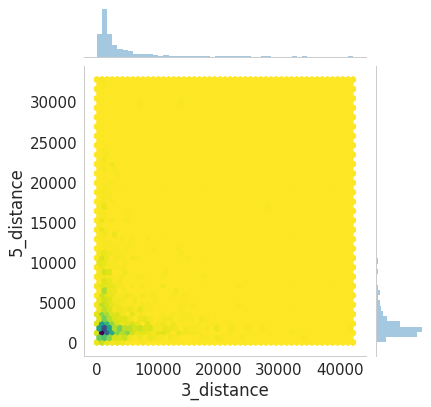

In [400]:
ax = sns.jointplot(e_to_g_merged['3_distance'], e_to_g_merged['5_distance'],kind='hex',\
                 cmap="viridis_r",stat_func=None, )

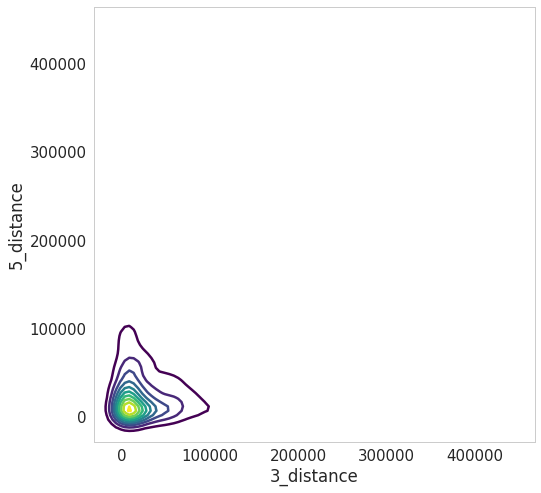

In [394]:
# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(e_to_g_merged['3_distance'], e_to_g_merged['5_distance'],
                 cmap="autumn", shade=True, shade_lowest=False, cut=0)
ax = sns.kdeplot(e_to_e_sub_merged['3_distance'], e_to_e_sub_merged['5_distance'],
                 cmap="viridis", shade=False, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("mako")[-2]
blue = sns.color_palette("viridis")[-2]
#ax.text(2.5, 8.2, "virginica", size=16, color=blue)
#ax.text(3.8, 4.5, "setosa", size=16, color=red)

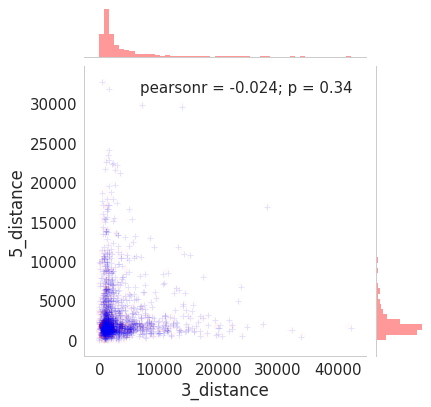

In [361]:
g = sns.jointplot(x="3_distance", y="5_distance", data=e_to_g_merged, kind="hex", color="r")
g.plot_joint(plt.scatter, c="b", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(1)
g.ax_joint.collections[1].set_alpha(0.1)

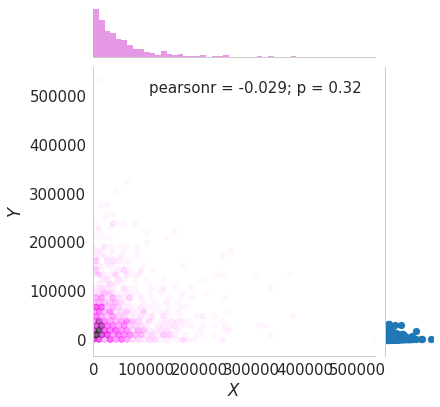

In [352]:
g = sns.jointplot(x="3_distance", y="5_distance", data=all_all_rand_merged, kind="hex", color="m")
plt.scatter(x=e_to_g_merged['3_distance'], y=e_to_g_merged['5_distance'])
g.ax_joint.collections[0].set_alpha(0.6)
#g.ax_joint.collections[1].set_alpha(0.2)
g.set_axis_labels("$X$", "$Y$");

In [310]:
prime_3_binneda

1         (41000, 42000]
2           (3000, 4000]
3         (29000, 30000]
4         (57000, 58000]
5         (57000, 58000]
6       (162000, 163000]
7         (32000, 33000]
8       (107000, 108000]
9       (107000, 108000]
10          (8000, 9000]
11        (11000, 12000]
12        (97000, 98000]
13        (21000, 22000]
14        (63000, 64000]
15          (3000, 4000]
16        (62000, 63000]
17        (48000, 49000]
18        (41000, 42000]
19        (19000, 20000]
20        (39000, 40000]
21        (39000, 40000]
22        (21000, 22000]
23        (31000, 32000]
24        (40000, 41000]
25        (40000, 41000]
26        (29000, 30000]
27          (1000, 2000]
28        (52000, 53000]
29      (197000, 198000]
30      (100000, 101000]
              ...       
1341      (38000, 39000]
1344        (1000, 2000]
1345      (24000, 25000]
1346        (1000, 2000]
1347      (15000, 16000]
1348      (15000, 16000]
1349      (21000, 22000]
1350      (21000, 22000]
1351      (23000, 24000]


In [306]:
all_all_rand_merged.columns

Index(['contig', '1_x', '2_x', 'query', '4_x', '5_x', '6_x', '7_x', '8_x',
       '3_target', '10_x', '11_x', '3_distance', '1_y', '2_y', '4_y', '5_y',
       '6_y', '7_y', '8_y', '5_target', '10_y', '11_y', '5_distance',
       '5_distance_log10', '3_distance_log10'],
      dtype='object')

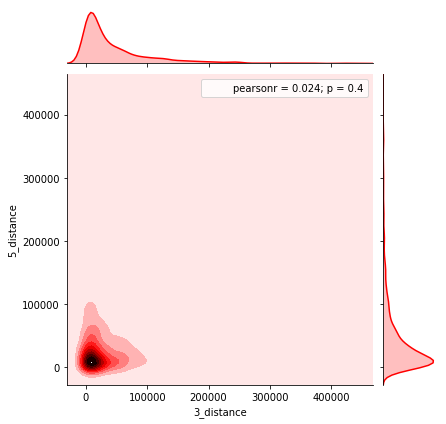

In [286]:

#do the same for effectors
#now for effectors 
#getting 5' and 3' distance
e_to_e_sub_3 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()
e_to_e_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_e_sub_5 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
e_to_e_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

#merging them
e_to_e_sub_merged = e_to_e_sub_3.merge(e_to_e_sub_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges
e_to_e_sub_merged = e_to_e_sub_merged [((e_to_e_sub_merged ['5_target'] != '.') & (e_to_e_sub_merged ['3_target'] != '.') )  ]
e_to_e_sub_merged ['5_distance'] = abs(e_to_e_sub_merged ['5_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=e_to_e_sub_merged , kind="kde", color='red')



In [287]:
p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, iu=True, D='a' ).to_dataframe().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,pcontig_000,40766,43007,evm.TU.pcontig_000.11,.,+,pcontig_000,60473,65016,evm.TU.pcontig_000.18,.,+,17467
1,pcontig_000,60473,65016,evm.TU.pcontig_000.18,.,+,pcontig_000,81210,81990,evm.TU.pcontig_000.22,.,+,16195
2,pcontig_000,81210,81990,evm.TU.pcontig_000.22,.,+,pcontig_000,310510,311517,evm.TU.pcontig_000.78,.,+,228521
3,pcontig_000,310510,311517,evm.TU.pcontig_000.78,.,+,pcontig_000,330481,334917,evm.TU.pcontig_000.82,.,-,18965
4,pcontig_000,330481,334917,evm.TU.pcontig_000.82,.,-,pcontig_000,310510,311517,evm.TU.pcontig_000.78,.,+,18965


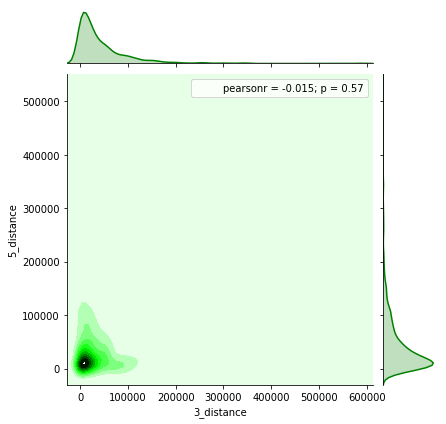

In [288]:

#now for busco
p_busco_bed_rand_sub_3 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, iu=True, D='a' ).to_dataframe()
p_busco_bed_rand_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_5 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
p_busco_bed_rand_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_merged = p_busco_bed_rand_sub_3.merge(p_busco_bed_rand_sub_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges see above for details
p_busco_bed_rand_sub_merged = p_busco_bed_rand_sub_merged[((p_busco_bed_rand_sub_merged['5_target'] != '.') & (p_busco_bed_rand_sub_merged['5_target'] != '.') )]
p_busco_bed_rand_sub_merged['5_distance'] = abs(p_busco_bed_rand_sub_merged['5_distance'])
sns.jointplot(x='3_distance', y='5_distance', data=p_busco_bed_rand_sub_merged, kind="kde" ,color = 'green')

#now start plotting stuff
#sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
#sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)




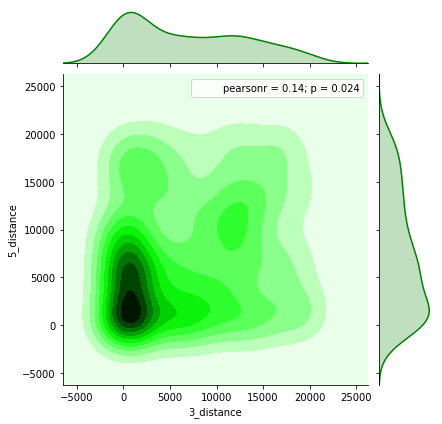

In [289]:
#some more plotting for when subsetting the dataframe to exclude outliers
sns.jointplot(x='3_distance', y='5_distance', data=p_busco_bed_rand_sub_merged[(p_busco_bed_rand_sub_merged['5_distance'] < 20000)&\
                                                                              (p_busco_bed_rand_sub_merged['3_distance'] < 20000)],\
              kind="kde" ,color = 'green')

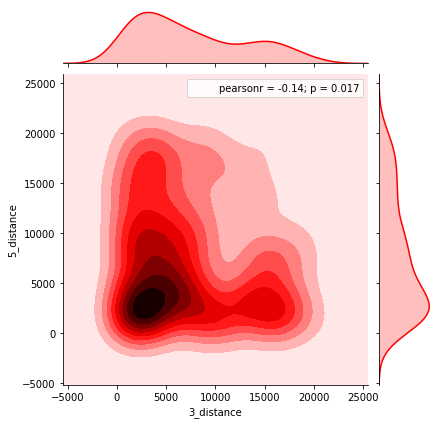

In [290]:
#some more plotting for when subsetting the dataframe to exclude outliers
sns.jointplot(x='3_distance', y='5_distance', data=e_to_e_sub_merged[(e_to_e_sub_merged['5_distance'] < 20000)&\
                                                                              (e_to_e_sub_merged['3_distance'] < 20000)],\
              kind="kde" ,color = 'red')

In [291]:
#looking more into the distance distribution between effectors use the index for this purpose and groupby or filteirng by 
#contig
#getting 5' and 3' distance


In [294]:
#getting 5' and 3' distance
e_to_e_sub_distance = e_to_e_sub_3.merge(e_to_e_sub_5, on = ['query','contig'])

#convert negative -1 from bedtools closest to nan and make values absolute
tmp_index = e_to_e_sub_distance[e_to_e_sub_distance['5_target'] == '.'].index.tolist()
e_to_e_sub_distance.loc[tmp_index, '5_distance'] = np.nan
e_to_e_sub_distance['5_distance'] = abs(e_to_e_sub_distance['5_distance'])
e_to_e_sub_distance['5_distance'].fillna(-1) 
#convert -1 from bedtools closest to nan in 3_distance
tmp_index = e_to_e_sub_distance[e_to_e_sub_distance['3_target'] == '.'].index.tolist()
e_to_e_sub_distance.loc[tmp_index, '3_distance'] = -1



#now subset the dataframe for a fixed distance 
max_distance = 15000
#subset the df and get the index first by distance and than by linkage (remember everything at the edges got a  -1 as distance)
e_to_e_less_d_df = e_to_e_sub_distance[\
                        ((e_to_e_sub_distance['3_distance'] <max_distance)&(e_to_e_sub_distance['3_distance'] > - 1)) \
                                       | 
                        ((e_to_e_sub_distance['5_distance'] <max_distance) &(e_to_e_sub_distance['5_distance'] > -1))  ]

#everything at the edges got a  -1 as distance


#get the max distance of two consective genes in teh e_to_e_less_d_df. It could be to have A-B close and C-D close but not B-C currently
#this would not have gotten caught.

e_to_e_less_d_df['next_distance'] = abs(e_to_e_less_d_df.shift(-1)['1_x'] - e_to_e_less_d_df['2_x'])

#now set everything that is not on consecutive contigs max_distance +1
nex_contig_index = e_to_e_less_d_df[e_to_e_less_d_df.shift(-1)['contig'] != e_to_e_less_d_df['contig']].index.values

e_to_e_less_d_df.loc[nex_contig_index, 'next_distance'] = max_distance +1

#get the index values and not the series
e_to_e_less_d_df_index = e_to_e_less_d_df.index.values

#transfer the next_distance of the linked once the main datframe and make everything else max_distance +1

e_to_e_sub_distance['next_linked_distance'] = max_distance +1

e_to_e_sub_distance.loc[e_to_e_less_d_df_index, 'next_linked_distance'] = e_to_e_less_d_df.next_distance


#introduce new column 'linked' and make this 1 were the genes are linked (e.g. less than max distance apart)
e_to_e_sub_distance['linked'] =0
e_to_e_sub_distance.loc[e_to_e_less_d_df_index, 'linked']  = 1
#get a new columns linkage_group that is 0 for now
e_to_e_sub_distance['linkage_group'] = 0

#get linkage groups first filtered by consecutive index
tmp_linkage_groups = ((e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].linked \
                      != e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].linked.index.to_series().diff().eq(1))).cumsum()\
#this also adds together genes that are not really linked because they are on a different contig or A-B close and C-D close but not B-C
e_to_e_sub_distance.loc[e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].index, 'tmp_lg']  = tmp_linkage_groups

test = e_to_e_sub_distance[e_to_e_sub_distance.linked == 1]
#the indexes are consectutive as indicated by the tmp linkage_group
unlinked_lg_index = test[(test.tmp_lg.shift(-1) == test.tmp_lg)][(test[(test.tmp_lg.shift(-1) == test.tmp_lg)]\
                                              ['next_linked_distance'] > max_distance)]
unlinked_lg_index = (test[(test.tmp_lg.shift(-1) == test.tmp_lg)]\
                                              ['next_linked_distance'] > max_distance)
#combine this remove unlinked_lg_indexs from initial linkage group by making everything Flase that is not linked.
tmp_linkage_groups = ((e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].linked \
                      != e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].linked.index.to_series().diff().eq(1))\
| unlinked_lg_index.shift(1)).cumsum()
e_to_e_sub_distance.loc[e_to_e_sub_distance[e_to_e_sub_distance.linked == 1].index, 'linkage_group']  = tmp_linkage_groups
#now loop over the contigs and connect the consecutive linked effectors (e.g. linked == 1) with a cumsum 
#for contig in e_to_e_sub_distance['contig'].unique():
   # tmp_df = e_to_e_sub_distance[e_to_e_sub_distance.contig == contig]
    #check were the index difference is not one and add it up
    #tmp_linkage_groups = (tmp_df[tmp_df.linked == 1].linked != tmp_df[tmp_df.linked == 1].linked.index.to_series().diff().eq(1)).cumsum() 
    # e_to_e_sub_distance.loc[tmp_df[tmp_df.linked == 1].index, 'linkage_group'] =  tmp_linkage_groups
    #print(contig)
#e_to_e_sub_distance = e_to_e_sub_distance.loc[:,['contig', 'query', '3_target',\
                                        # '3_distance', '5_target', '5_distance', 'linked', 'linkage_group', 'next_linked_distance']]


e_to_e_sub_distance = e_to_e_sub_distance.loc[:,[ 'query', '3_target',\
                                         '5_target',  'linked', 'linkage_group', 'next_linked_distance']]
e_to_e_sub_distance['lg_freq'] = e_to_e_sub_distance.groupby('linkage_group')['linkage_group'].transform('count')

In [295]:
#makeing a function out of 5' and 3' distance bining
def _5_to_3_chains(_5_prime_df, _3_prime_df, max_distance=15000, label=''):
    """This function takes two dataframes one from _5_prime_ nearest neighbour and one from
    _3_prime_nearest neighbour. max_distance and label for the df columns can be added as well.
    Those should be generated with pybedtools and converted to dataframe
    without subsetting and with selecting the distance.
    Columns should be renamed as
    12:'3_distance', 3:'query', 9:'3_target', 0:'contig' for _3_prime
    and
    12:'5_distance', 3:'query', 9:'5_target', 0:'contig' for _5_prime
    The output will be new dataframe that contains the merged dataframes, the linked information, the linkage group,
    and the frequency of each linkage group = group member count.
    And a dataframe that summarizes the bin size, number within each bin and number of each bin.
    member_count_label	bin_size_label	number_of_bins_label
    """
    five_df = _5_prime_df.copy()
    three_df = _3_prime_df.copy()
    max_distance = max_distance
    
    #getting 5' and 3' distance
    distance_df = three_df.merge(five_df, on = ['query','contig'])

    #convert negative -1 from bedtools closest to nan and make values absolute
    tmp_index = distance_df[distance_df['5_target'] == '.'].index
    distance_df.loc[tmp_index, '5_distance'] = np.nan
    distance_df['5_distance'] = abs(distance_df['5_distance'])
    distance_df['5_distance'].fillna(-1, inplace = True) 
    #convert -1 from bedtools closest to nan in 3_distance
    tmp_index = distance_df[distance_df['3_target'] == '.'].index
    distance_df.loc[tmp_index, '3_distance'] = -1

    #subset the df and get the index first by distance and than by linkage (remember everything at the edges got a  -1 as distance)
    sub_distance_df = distance_df[\
                            ((distance_df['3_distance'] <max_distance)&(distance_df['3_distance'] > - 1)) \
                                           | 
                            ((distance_df['5_distance'] <max_distance) &(distance_df['5_distance'] > -1))  ]

    #get the max distance of two consective genes in teh distance_df. It could be to have A-B close and C-D close but not B-C currently
    #this would not have gotten caught. #to be illustrated

    sub_distance_df['next_distance'] = abs(sub_distance_df.shift(-1)['1_x'] - sub_distance_df['2_x'])

    #now set the distance to the next gene to max_distance +1 if the next contig is different
    #from the current one
    next_contig_index = sub_distance_df[sub_distance_df.shift(-1)['contig'] != sub_distance_df['contig']].index.values

    sub_distance_df.loc[next_contig_index, 'next_distance'] = max_distance +1

    #get the index values and not the series
    sub_distance_df_index = sub_distance_df.index.values

    #transfer the next_distance of the linked once the main datframe and make everything else max_distance +1

    distance_df['next_linked_distance'] = max_distance +1

    distance_df.loc[sub_distance_df_index, 'next_linked_distance'] = sub_distance_df.next_distance


    #introduce new column 'linked' and make this 1 were the genes are linked (e.g. less than max distance apart)
    distance_df['linked'] =0
    distance_df.loc[sub_distance_df_index, 'linked']  = 1
    #get a new columns linkage_group that is 0 for now
    distance_df['linkage_group'] = 0

    #get linkage groups first filtered by consecutive index
    tmp_linkage_groups = ((distance_df[distance_df.linked == 1].linked \
                          != distance_df[distance_df.linked == 1].linked.index.to_series().diff().eq(1))).cumsum()\
    
    #this also adds together genes that are not really linked because they are on a different contig or A-B close and
    #C-D close but not B-C. We need to take care of this later on using the next_linked_distance column
    distance_df.loc[distance_df[distance_df.linked == 1].index, 'tmp_lg']  = tmp_linkage_groups
    
    #generate a new sub_distance_df that has all colmuns as the main distance df
    sub_distance_df = distance_df[distance_df.linked == 1]
    
    #the indexes are consectutive as indicated by the tmp linkage_group. 
    #now identify where linked sequences are separated by more than the max_distance. This includes intercontigs breaks.
    
    unlinked_lg_index = (sub_distance_df[(sub_distance_df.tmp_lg.shift(-1) == sub_distance_df.tmp_lg)]\
                                                  ['next_linked_distance'] > max_distance)
    
    #combine this remove unlinked_lg_indexs from initial linkage group by making everything Flase that is not linked.
    #this requires to 'add' the unlinked_lg_index boolean array to the consecutive boolean array using an or |
    #meaning only the Trues are transfered and this needs to be shiffted one downward (could have also done previous distance and not
    #next)
    
    tmp_linkage_groups = ((distance_df[distance_df.linked == 1].linked \
                          != distance_df[distance_df.linked == 1].linked.index.to_series().diff().eq(1))\
    | unlinked_lg_index.shift(1)).cumsum()
    
    distance_df.loc[distance_df[distance_df.linked == 1].index, 'linkage_group']  = tmp_linkage_groups
    
    distance_df = distance_df.loc[:,['contig', 'query', '3_target',\
                                            '3_distance', '5_target', '5_distance', 'linked', 'linkage_group']]
    #add a frequency columns to the dataframe
    distance_df['lg_freq'] = distance_df.groupby('linkage_group')['linkage_group'].transform('count')
    
    #now make a bin count dataframe
    
    #get the counts for each lg_freq == total number of genes in a bin of size lg_freq
    bins = distance_df[distance_df.linked !=0 ].groupby('lg_freq').count()
    
    #now get unlinked total number of genes ina bin size of 1
    bin_one = distance_df[distance_df.linked ==0 ].groupby('lg_freq').count().reset_index(drop= True)

    bin_one.index = [1] 
    #combine both
    all_bins = bins.append(bin_one)
    #use the index which represents the bin size
    all_bins['bin_size'] = all_bins.index
    
    all_bins = all_bins.sort_values('bin_size').reset_index(drop=True).loc[:, ['linked', 'bin_size']]

    all_bins.rename(columns={'linked': 'member_count'}, inplace=True)

    all_bins['number_of_bins'] = all_bins['member_count'] / all_bins['bin_size']

    #new_cnames = ['%s_%s' % (x,label) for x in all_bins.columns]

    #all_bins.rename(columns=dict(zip(all_bins.columns, new_cnames)), inplace=True)
    
    all_bins['label'] = label
    
    #all_bins['bin_size'] = all_bins['bin_size_' + label]
    return distance_df, all_bins

In [296]:
max_distance = 12000

In [297]:
distance_effector_df, bin_effector_df = _5_to_3_chains(e_to_e_sub_5,e_to_e_sub_3,max_distance=max_distance, label='effector') 

In [298]:
distance_busco_df, bin_busco_df = _5_to_3_chains(p_busco_bed_rand_sub_5,p_busco_bed_rand_sub_3,max_distance=max_distance, label='busco')

In [299]:
distance_all_gene_df, bin_all_gene_df = _5_to_3_chains(all_all_rand_5,all_all_rand_3,max_distance=max_distance, label = 'all_genes')

In [300]:
overall_bining_df = pd.concat([bin_effector_df,bin_busco_df,bin_all_gene_df ])

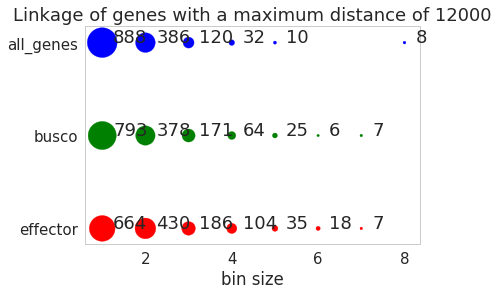

In [301]:
#set yourself up for the plots
overall_bining_df['member_count_log'] = np.log2(overall_bining_df.member_count)

conversion_dict = dict(zip(overall_bining_df.label.unique(), range(1,4)))
conversion_dict_color = dict(zip(overall_bining_df.label.unique(), ['r', 'g', 'b']))

#get the data labels and the color labels
overall_bining_df['number_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict[x])
overall_bining_df['color_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict_color[x])

#set the overall sns style
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#start the figure
fig, ax = plt.subplots(1,1)
title = "Linkage of genes with a maximum distance of %i" % max_distance
#fill the figure with a scatter plot
ax.scatter(overall_bining_df.bin_size, overall_bining_df.number_labels, s=overall_bining_df.member_count, \
           color =overall_bining_df['color_labels'] )
#add the labels
for label, x, y in zip(overall_bining_df.member_count,overall_bining_df.bin_size, overall_bining_df.number_labels ):
    plt.annotate(label, xy =(x+0.25,y))
plt.xlabel('bin size')
ax.set_yticks(range(1,4))
ax.set_yticklabels(overall_bining_df.label.unique())
plt.title(title)
out_file_name = "_".join(title.split(' '))
fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'.png'), dpi=600)

In [303]:
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

Quick look at allele analysis

In [302]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12'
BASE_A_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
BLAST_RESULT_PATH = os.path.join(BASE_AA_PATH,'allele_analysis' )
ALLELE_PATH =os.path.join(BASE_AA_PATH ,'allele_analysis/alleles_proteinortho_graph516')
ALLELE_QC_PATH = os.path.join(BASE_AA_PATH, 'allele_analysis', \
                              'no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
LIST_PATH = os.path.join(BASE_AA_PATH, 'enrichment_analysis', 'lists')
POST_ALLELE_PATH = os.path.join(BASE_AA_PATH, 'post_allele_analysis')
OUT_PATH = os.path.join(POST_ALLELE_PATH, 'proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
if not os.path.exists(POST_ALLELE_PATH):
    os.mkdir(POST_ALLELE_PATH)
if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

In [117]:
#get all the alleles in as they are not filtered by QCov and PctID but simply taken straight from the 
# proteinortho
allele_header = ['p_gene', 'h_gene']
a_overlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_overlap_df['Linkage'] = 'h_contig_overlap'
a_no_roverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_roverlap_df['Linkage'] = 'no_r_overlap'
a_no_soverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_soverlap_df['Linkage'] = 'no_s_overlap'
allele_df = pd.concat([a_overlap_df, ], axis=0)

In [118]:
#get the blast dataframe and the QC dataframe
allele_blast_df = pd.read_csv(os.path.join(BLAST_RESULT_PATH, 'Pst_104E_v12_p_ctg.Pst_104E_v12_h_ctg.0.001.blastp.outfmt6.allele_analysis'), sep='\t')
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')
allele_QC_df = allele_QC_df[~((allele_QC_df.Query.isin(allele_df.p_gene))|(allele_QC_df.Query.isin(allele_df.h_gene)))]
#quick check if all the numbers of genes add up
len(allele_df.p_gene.unique())+ len(allele_df.h_gene.unique())+len(allele_QC_df.Query.unique()) == 30249

/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


False

In [119]:
#now look abit into it all

In [120]:
import joypy

In [121]:
#make a new column linking stuff together
allele_blast_df['match'] = allele_blast_df.Query + allele_blast_df.Target
allele_df['match'] = allele_df.p_gene + allele_df.h_gene

In [122]:
allele_hits_only_df = allele_blast_df[(allele_blast_df.match.isin(allele_df.match))].copy()

In [123]:
len(allele_hits_only_df)

9805

In [124]:
import scipy.stats as stats

In [125]:
effecter_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(p_effector_list))]['PctID'].tolist()

In [126]:
noeffecter_bpctid = allele_hits_only_df[~(allele_hits_only_df.Query.isin(p_effector_list))]\
['PctID'].tolist()

In [127]:
busco_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(p_busco_list))]['PctID'].tolist()

In [128]:
non_busco_list = pd.read_csv(p_non_busco_list_fn, sep='\t', header =None)[0].tolist()
non_be_list = pd.read_csv(p_noeffectorp_nobusco_bed_fn, sep='\t', header =None)[3].str.replace('TU', 'model').tolist()

In [129]:
non_busco_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(non_busco_list))]['PctID'].tolist()
non_be_list_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(non_be_list))]['PctID'].tolist()

In [130]:
stats.ranksums(effecter_bpctid, non_be_list_bpctid)

RanksumsResult(statistic=3.5807395602420549, pvalue=0.00034262304280770385)

In [131]:
stats.ranksums(non_be_list_bpctid, busco_bpctid )

RanksumsResult(statistic=-6.9491573631048498, pvalue=3.6747446866090623e-12)

In [132]:
bpctid_df = pd.concat([pd.Series(effecter_bpctid),pd.Series(noeffecter_bpctid)\
                          , pd.Series(busco_bpctid), pd.Series(non_busco_bpctid)\
                      ,pd.Series(non_be_list_bpctid)], axis=1)

In [133]:
bpctid_df.rename(columns={0: 'effector', 1:'no_effector', 2: 'buscos', 3: 'non_buscos',\
                         4:'no_be'}, inplace=True)

In [134]:
bpctid_melt_df = bpctid_df.melt()

[]

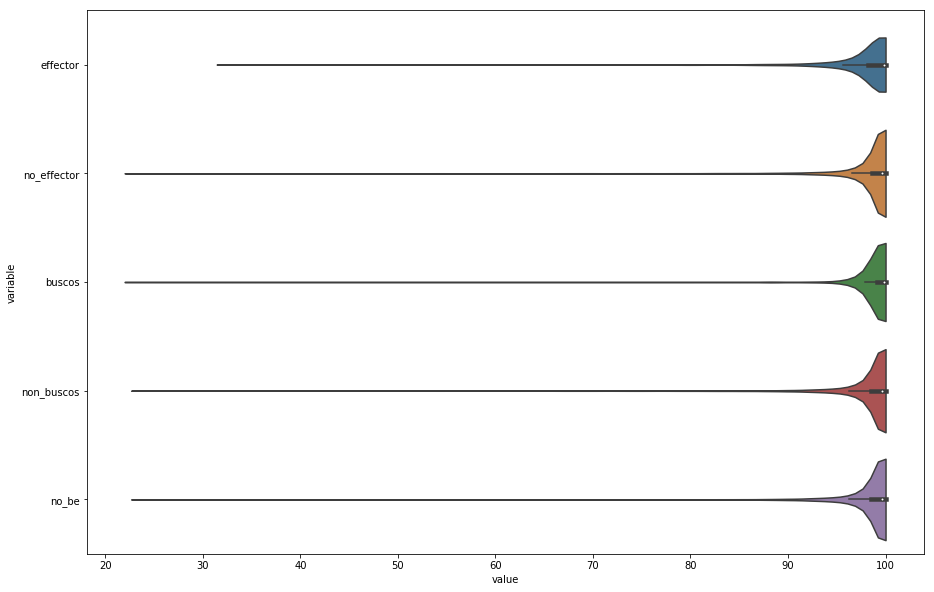

In [135]:
f, ax = plt.subplots(figsize=(15, 10))
#ax.set_xscale("log")
sns.violinplot(x="value", y="variable", data=bpctid_melt_df, cut=0,
          whis=np.inf, saturation=0.5)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x="value", y="variable", data=bpctid_melt_df,
  #            size=2, color=".3", linewidth=0)

In [136]:
stats.mstats.kruskalwallis([float(x) for x in bpctid_df.effector.dropna()]\
                           ,[float(x) for x in bpctid_df.no_be.dropna()],\
                          [float(x) for x in bpctid_df.buscos.dropna()])

KruskalResult(statistic=57.798053437970822, pvalue=2.8139227039850055e-13)

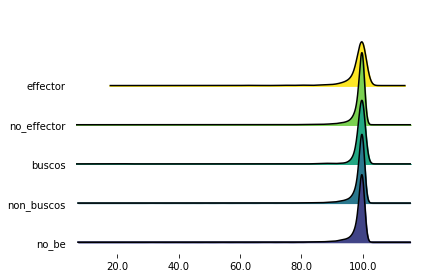

In [137]:
from matplotlib import cm
fig, axes = joypy.joyplot(bpctid_df, colormap=cm.viridis_r, range_style='own')

In [138]:
bpctid_df.describe()

,effector,no_effector,buscos,non_buscos,no_be
count,1115.000000,8690.000000,1116.000000,8689.000000,7975.000000
mean,97.964807,98.375474,98.995018,98.243203,98.236675
std,5.569901,4.691931,4.201319,4.866646,4.873606
min,31.430000,21.980000,21.980000,22.650000,22.650000
25%,98.235000,98.610000,99.167500,98.490000,98.480000
50%,99.830000,99.640000,99.800000,99.630000,99.610000
75%,100.000000,100.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000


Truely allelic effectors are slightly more variable than everything else. Look if the SNP rates are different too. Looking at coding and non-coding SNP changes.

Do some analysis on windows. Make 30kb windows and 100kb windows sliding by 1000bp
Then caculate the GC content, BUSCO content, EFFECTOR content, Gene content, secreted proteins, haustoria expressed proteins and plot this all out.

In [556]:
W_PATH = os.path.join(BASE_AA_PATH, 'window_analysis')
if not os.path.exists(W_PATH):
    os.mkdir(W_PATH)

In [568]:
#make some windows beds
window_fn_dict = {}
window_bed_dict = {}
window_fn_dict['w30kb_s1kb_fn'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w30.s1.bed')
window_fn_dict['w100kb_s1kb_fn'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w100.s1.bed')
window_fn_dict['w30kb_fn'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w30.bed')
window_fn_dict['w100kb_fn'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w100.bed')
genome_size_f_fn = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.genome_file')
contig_fn = os.path.join(GFF_FOLDER,'Pst_104E_v12_p_ctg.fa' )
os.chdir(W_PATH)
#now make the window files
!bedtools makewindows -g {genome_size_f_fn} -w 100000 -s 1000 > {window_fn_dict['w100kb_s1kb_fn']}
!bedtools makewindows -g {genome_size_f_fn} -w 30000 -s 1000 > {window_fn_dict['w30kb_s1kb_fn']}
!bedtools makewindows -g {genome_size_f_fn} -w 100000 > {window_fn_dict['w100kb_fn']}
!bedtools makewindows -g {genome_size_f_fn} -w 30000 > {window_fn_dict['w30kb_fn']}

In [570]:
#new make a bedtools window dataframe
for key, value in window_fn_dict.items() :
    window_bed_dict[key] = BedTool(value)

In [580]:
#now make an AT bed df dict and save it out
window_AT_dict = {}
for key, value in window_bed_dict.items():
    tmp_df = value.nucleotide_content(fi=contig_fn).to_dataframe().iloc[1:,[0,1,2, 3]]
    tmp_df.rename(columns={'name':'%AT'}, inplace=True)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.bed')
    tmp_df.to_csv(tmp_fn, header=None, sep='\t', index=None)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.circa')
    tmp_df.to_csv(tmp_fn, sep='\t', index=None)
    window_AT_dict[key] = tmp_df
    tmp_df = ''

In [579]:
feature_fn_dict = {}
feature_fn_dict['genes'] = os.path.join(LIST_PATH)

,chrom,start,end,%AT
1,pcontig_000,0,30000,0.546867
2,pcontig_000,1000,31000,0.549067
3,pcontig_000,2000,32000,0.550933
4,pcontig_000,3000,33000,0.553567
5,pcontig_000,4000,34000,0.554300
6,pcontig_000,5000,35000,0.552400
7,pcontig_000,6000,36000,0.553500
8,pcontig_000,7000,37000,0.554867
9,pcontig_000,8000,38000,0.556667
10,pcontig_000,9000,39000,0.558067


In [563]:
!ls {GFF_FOLDER}

hcontig_greater_2000.txt	    Pst_104E_v12_p_ctg.fa
hcontig_smaller_2000.txt	    Pst_104E_v12_p_ctg.fa.fai
pcontig_greater_2000.txt	    Pst_104E_v12_p_ctg.genome_file
pcontig_smaller_2000.txt	    Pst_104E_v12_p_ctg.REPET.gff
Pst_104E_v12_h_ctg.anno.CDS.fa	    Pst_104E_v12_ph_ctg.anno.CDS.fa
Pst_104E_v12_h_ctg.anno.CDS.gff3    Pst_104E_v12_ph_ctg.anno.CDS.gff3
Pst_104E_v12_h_ctg.anno.gene.fa     Pst_104E_v12_ph_ctg.anno.gene.fa
Pst_104E_v12_h_ctg.anno.gff3	    Pst_104E_v12_ph_ctg.anno.gff3
Pst_104E_v12_h_ctg.anno.protein.fa  Pst_104E_v12_ph_ctg.anno.protein.fa
Pst_104E_v12_h_ctg.fa		    Pst_104E_v12_ph_ctg.fa
Pst_104E_v12_h_ctg.fa.fai	    Pst_104E_v12_ph_ctg.fa.fai
Pst_104E_v12_h_ctg.genome_file	    Pst_104E_v12_ph_ctg.REPET.gff
Pst_104E_v12_h_ctg.REPET.gff	    Pst_104E_v12_pwh_ctg.anno.gff3
Pst_104E_v12_p_ctg.anno.CDS.fa	    Pst_104E_v12_pwh.txt
Pst_104E_v12_p_ctg.anno.CDS.gff3    Pst_104E_v12_pwoh_ctg.anno.gff3
Pst_104E_v12_p_ctg.anno.gene.fa     Pst_104E_v12_pwoh.txt
Pst_104E_v12_p_ct

Next plot out the allele variation against of effectors against distance to TEs and BUSCOS.
Also plot out 